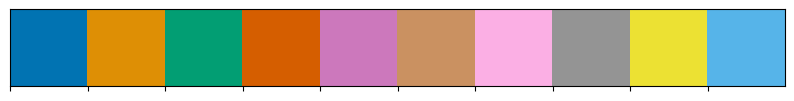

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import fnmatch
pal = sns.color_palette("colorblind",10)
sns.palplot(pal)

In [2]:
## Functions
def get_local(reg):
    loclatlon = {'SGP':'36.605 -97.485',\
               'ENA':'39.091 -28.026',\
               'NSA':'71.322 -156.615',\
               'TCAP':'42.5 -71',\
               'TWP':'-2.06 147.425',\
                'HAE':'42 -71',\
                'IND':'20.5 79',\
                'GOSAN':'33.2833 126.1667',\
                'NSA':'71.3228 -156.6144',\
                'ENA':'39.09 -28.03',\
                'TCAP':'41.69 -70.29',\
                'TRACER':'29.67 -95.06',\
                'LASIC':'-7.97 -14.35',\
                'GoAmazon':'-3.1131 -60.0253'}
    lat1 = float(loclatlon[reg].split(' ')[0])
    lon1 = float(loclatlon[reg].split(' ')[1])
    return lat1,lon1

def get_nearestlatlon(lon1,lat1,lon,lat):
    try:
        ind=np.argmin((lon-lon1)**2+(lat.values-lat1)**2)
        lat1,lat2,lon1,lon2 = lat[ind],lat[ind],lon[ind],lon[ind]
    except:
        RLLlon = lon.sel(lon=lon1, method='nearest')
        RLLlat = lat.sel(lat=lat1, method='nearest')
        lat1,lat2,lon1,lon2 = RLLlat,RLLlat,RLLlon,RLLlon
    return lat1,lat2,lon1,lon2

def get_val(n4,lon,lat, val='SGP'):
    lat1,lon1=get_local(val)
    lat1,lat2,lon1,lon2 = get_nearestlatlon(lon1,lat1,lon,lat)
    n4 = n4.where((lon>=lon1) & (lon<=lon2))
    n4 = n4.where((lat>=lat1) & (lat<=lat2))
    n4 = n4.dropna(dim='ncol')
    return n4

def get_plot_info(nvals,dgns,lev,modlist=[0,1,2,3]):
    smallv = np.power(10.,-30.)
    yy = np.array(nvals)[:,lev]
    tmpb = np.array(dgns)[:,lev]
    P = 300
    T = 239.5
    aircon = P * 100. / 8.31446261815324 / T
    fact_kgpkg_kgpcm3 = 1.01325e5 / 8.31446261815324 / 273.15 * 28.9647 / 1.e9
    # set basic parameters
    sim_t      = np.array([3600])        # simulation length

    #sigmag     = [1.8,1.8,1.8,1.8]                      # sigmag of each mode
    sigmag     = [1.8,1.6,1.8,1.6]
    #consta     = 1./(np.sqrt(2.*np.pi)*xx*np.log(sigmag))      # constant for log-normal distribution

    # axis property
    x_low      = -9
    x_upp      = -6
    x_lower    = np.power(10.,x_low)
    x_upper    = np.power(10.,x_upp)
    x_label    = np.power(10.,np.arange(x_low,x_upp+1,1))
    xtitle     = 'Aerosol diameter '+r'$\rm D_p \enspace (m)$'
    xx         = np.power(10.,np.linspace(x_low,x_upp,1000))      # sample diameter points for plot

    y_low      = 0
    y_upp      = 4
    y_lower    = np.power(10.,y_low)
    y_upper    = np.power(10.,y_upp)
    y_label    = np.power(10.,np.arange(y_low,y_upp+1,1))
    ytitle     = 'Aerosol number concentration '+r'$\rm (cm^{-3})$'

    # calculate size distribution 
    mode = 4
    zz = np.zeros([xx.size])           
    for n in modlist:
        print(tmpb[n])
        if  tmpb[n] > 0.:
            expon   = np.power((np.log(xx)-np.log(tmpb[n]))/(np.sqrt(2.)*np.log(sigmag[n])),2.)
            consta     = 1./(np.sqrt(2.*np.pi)*np.log(sigmag[n]))
            constb  = np.exp(-1.*expon)
            zz      = zz+consta*constb*yy[n]
            del(expon,constb)
    zz = zz * fact_kgpkg_kgpcm3   # convert 1/kmol to 1/cm3   
    zz = np.where(zz < smallv, smallv, zz)
    return xx, zz, x_lower, x_upper, y_lower, y_upper, x_label, y_label, xtitle, ytitle, tmpb[n]

1.5389185963058853e-07
1.0634032924851814e-07


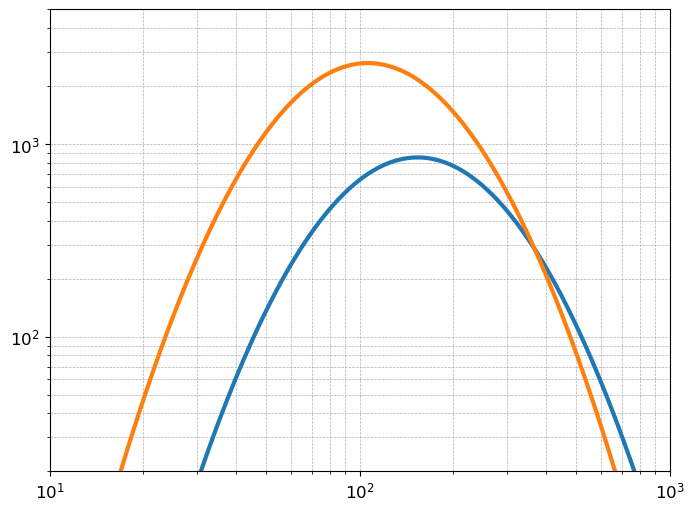

In [18]:
loc = 'GoAmazon'
lev = 71
j = [0]

dfile = 'F20TR_2016Emis_ne30pg2_control.eam.ANN.2016_climo.nc'
pfile = 'F20TR_2016Emis_ne30pg2_highUB.eam.ANN.2016_climo.nc'
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for file in [dfile,pfile]:
    data = xr.open_mfdataset('/global/cfs/projectdirs/m3525/mhass004/clim_out/'+file)
    lon = data['lon'].values
    lon[lon > 180.] -= 360.
    lat = data['lat']
    nvals = []
    dgns = []
    for i in [1,2,3,4]:
        n4 = data['num_a'+str(i)]
        dgn = data['dgnd_a0'+str(i)]
        n4 = get_val(n4, lon,lat,val=loc)
        nvals.append(n4[:,0].values)
        dgn = get_val(dgn, lon,lat,val=loc)
        dgns.append(dgn[:,0].values)
    xx, zz, x_lower, x_upper, y_lower, y_upper, x_label, \
    y_label, xtitle, ytitle, dg = get_plot_info(nvals,dgns,lev,modlist=j)
    ax.plot(xx*1e9, zz*np.log(10), linewidth=3)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.set_xlim([1e1,1e3])
    ax.set_ylim([2e1,5e3])

1.6971501586122277e-07
2.6904951842079627e-08
1.261448882397504e-06
9.994096153028693e-08
1.4402606823700996e-07
2.701069510888604e-08
1.2591888774557147e-06
4.90219127245899e-08


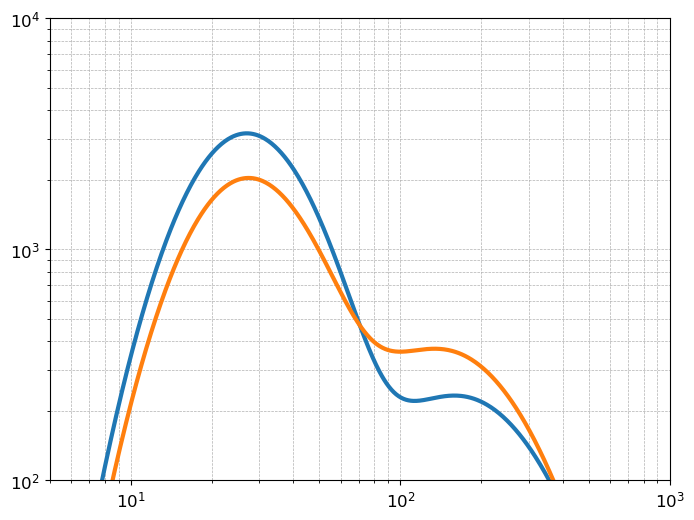

In [22]:
loc = 'ENA'
lev = 71
j = [0,1,2,3]

dfile = 'F20TR_2016Emis_ne30pg2_control.eam.ANN.2016_climo.nc'
pfile = 'F20TR_2016Emis_ne30pg2_highUB.eam.ANN.2016_climo.nc'
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for file in [dfile,pfile]:
    data = xr.open_mfdataset('/global/cfs/projectdirs/m3525/mhass004/clim_out/'+file)
    lon = data['lon'].values
    lon[lon > 180.] -= 360.
    lat = data['lat']
    nvals = []
    dgns = []
    for i in [1,2,3,4]:
        n4 = data['num_a'+str(i)]
        dgn = data['dgnd_a0'+str(i)]
        n4 = get_val(n4, lon,lat,val=loc)
        nvals.append(n4[:,0].values)
        dgn = get_val(dgn, lon,lat,val=loc)
        dgns.append(dgn[:,0].values)
    xx, zz, x_lower, x_upper, y_lower, y_upper, x_label, \
    y_label, xtitle, ytitle, dg = get_plot_info(nvals,dgns,lev,modlist=j)
    ax.plot(xx*1e9, zz*np.log(10), linewidth=3)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.set_xlim([5,1e3])
    ax.set_ylim([1e2,1e4])

In [3]:
def get_local(reg):
    loclatlon = {'SGP':'36.605 -97.485',\
               'ENA':'39.091 -28.026',\
               'NSA':'71.322 -156.615',\
               'TCAP':'42.5 -71',\
               'TWP':'-2.06 147.425',\
                'HAE':'42 -71',\
                'IND':'20.5 79',\
                'GOSAN':'33.2833 126.1667',\
                'NSA':'71.3228 -156.6144',\
                'ENA':'39.09 -28.03',\
                'TCAP':'41.69 -70.29',\
                'TRACER':'29.67 -95.06',\
                'LASIC':'-7.97 -14.35',\
                'GoAmazon':'-3.1131 -60.0253'}
    lat1 = float(loclatlon[reg].split(' ')[0])
    lon1 = float(loclatlon[reg].split(' ')[1])
    return lat1,lon1

def get_latlon(reg):
    regions = {'CONUS':'24.74 49.34 -124.78 -66.95',\
              'NA':'15 72 -167 -50',\
              'EUS':'24.74 49.34 -97 -66.95',\
              'ECN':'18 45 90 130',\
              'IND':'6 40 66 98',\
              'CAF':'-5 20 -18 50', \
               'SH_pole':'-90 -60 -180 180',\
              'SH_midlat':'-60 -30 -180 180',\
              'Tropics':'-30 30 -180 180',\
              'NH_midlat':'30 60 -180 180',\
              'NH':'0 90 -180 180',\
              'SH':'-90 0 -180 180',\
              'NH_pole':'60 90 -180 180',\
              'Global':'-90 90 -180 180',\
              'CUS':'31 41 -104 -91',\
              'ENA':'32 46 -33 -21',\
              'NEP':'30 50 -160 -120',\
              'SO':'-60 -40 130 165'}
    lat1 = float(regions[reg].split(' ')[0])
    lat2 = float(regions[reg].split(' ')[1])
    lon1 = float(regions[reg].split(' ')[2])
    lon2 = float(regions[reg].split(' ')[3])
    return lat1,lat2,lon1,lon2

def rounding(n):
    if (type(n)==str) or (np.isnan(n)):
        return str('-')
    elif ((abs(n)>1e-4) and (abs(n)<1e4)):
        try:
            sgn = '-' if n<0 else ''
            num = format(abs(n)-int(abs(n)),'f')
            if int(num[2:])<1:
                d = str((abs(n)))
                return sgn + d
            else:
                for i,e in enumerate(num[2:]):
                    if e!= '0':
                        if i==0:
                            d = str(int(abs(n))) + (num[1:i+5])
                        else:
                            d = str(int(abs(n))) + (num[1:i+4])
                        return sgn+d
        except:
            return '-'
    else:
        return '{:.0e}'.format(n)


def get_vertint(vdata,ha,p0,hb,ps,grav,fact):
    ## calc. dp
    delp = 0*vdata
    p = ha*p0+hb*ps
    if 'ncol' in p.dims:
        p = p.transpose('ilev','ncol')
    else:
        p = p.transpose('ilev','lat','lon')
    delp = p[1:,:].values-p[:-1,:].values
    delp = delp + 0*vdata
    ## unit conversion and vertical integration
    vdata = vdata*(delp/grav) # p/g = Pa/ms^-2 = Nm^-2/ms^-2 = Kg.ms^-2/m^2/ms^-2
    vdata = vdata*fact
    vdata = vdata.sum('lev')
    return vdata

def get_tables(file,aer,ts='ANN',reg=None,loc=None,mod='eam',indl=None,land=False):
    data = xr.open_mfdataset('/global/cfs/projectdirs/m3525/mhass004/clim_out/'+file)
    lon = data['lon'].values
    lon[lon > 180.] -= 360.
    lat = data['lat']
    indl = None
    lat = data['lat']
    if reg!=None:
        lat1,lat2,lon1,lon2=get_latlon(reg)
    elif loc!=None:
        lat1,lon1=get_local(loc)
        lat1,lat2,lon1,lon2 = get_nearestlatlon(lon1,lat1,lon,lat)
    else:
        lat1,lat2,lon1,lon2=lat.values.min(),lat.values.max(),lon.min(),lon.max()
    if 'year' in data.coords:
        data = data.rename({'year':'season'})
    ## factors
    fact = 1e-9
    grav = 9.806
    ha = data['hyai']
    hb = data['hybi']
    p0 = data['P0']
    ps = data['PS']
    area = data['area']*(6.37122e6)**2
    landF = data['LANDFRAC']
    avgod = 6.022e+23
    mwso4 = 115.0
    factaa  = mwso4*10.0/avgod        # convert molec/cm2/s to kg/m2/s
    factaaa = 12.0*10.0/avgod         # convert molec/cm2/s to kg/m2/s
    factbb  = 86400.0*365.0*1e-9      # convert kg/s to Tg/yr
    if aer == 'num':  
        factbb  = 86400.0*365.0
        factaa = 1.e4/(avgod*1.e3)
    factcc  = factbb/mwso4*32.066     # convert kg/s to TgS/yr
    factdd  = 32.066/mwso4*1e-9       # convert kg to TgS
    sum_airmass = ((ps*area).sum()/grav)*1e6
    fact_kgpkg_kgpcm3 = 1.01325e5 / 8.31446261815324 / 273.15 * 28.9647 / 1.e9   # kg-air/cm3-air
    fact_kgpcm3_ugpm3 = fact_kgpkg_kgpcm3 * 1e15
    
    ## all variable list
    vlist = list(data.variables.keys())
    # List of all variables considered
    avariables = [aer+'_a?',aer+'_a?'+'DDF',aer+'_a?'+'SFWET','SF'+aer+'_a?',aer+'_a?'+'_CLXF',\
     aer+'_a?'+'_sfgaex1',aer+'_a?'+'GVF',aer+'_a?'+'TBF',aer+'_a?'+'SFSIS',\
     aer+'_a?'+'SFSIC',aer+'_a?'+'SFSBS',aer+'_a?'+'SFSBC',aer+'_a?'+'SFSES',\
     aer+'_a?'+'SFSEC',aer+'_a?'+'_sfgaex2',aer+'_a?'+'_sfcoag1',aer+'_a?'+'_sfcsiz3',\
     aer+'_a?'+'_sfcsiz4',aer+'_a?'+'_mixnuc1',aer+'_a?'+'AQH2SO4',\
     aer+'_a?'+'AQSO4',aer+'_a?'+'_sfnnuc1','AQ_'+aer+'_a?','GS_'+aer+'_a?',aer+'_a?']
    cvariables = [aer+'_c?',aer+'_c?'+'DDF',aer+'_c?'+'SFWET','SF'+aer+'_c?',aer+'_c?'+'_CLXF',\
     aer+'_c?'+'_sfgaex1',aer+'_c?'+'GVF',aer+'_c?'+'TBF',aer+'_c?'+'SFSIS',\
     aer+'_c?'+'SFSIC',aer+'_c?'+'SFSBS',aer+'_c?'+'SFSBC',aer+'_c?'+'SFSES',\
     aer+'_c?'+'SFSEC',aer+'_c?'+'_sfgaex2',aer+'_c?'+'_sfcoag1',aer+'_c?'+'_sfcsiz3',\
     aer+'_c?'+'_sfcsiz4',aer+'_c?'+'_mixnuc1',aer+'_c?'+'AQH2SO4',\
     aer+'_c?'+'AQSO4',aer+'_c?'+'_sfnnuc1','AQ_'+aer+'_c?','GS_'+aer+'_c?',aer+'_c?']
    
    ## handle gas=phase species
    gvars = ['SO2','DMS','H2SO4','SOAG']
    if aer in gvars:
        avariables = str(avariables).replace('_a?','').replace("'",'').replace(' ','')[1:-1].replace(aer+'DDF','DF_'+aer).replace(aer+'SFWET','WD_'+aer).split(',')
        cvariables = ['']*len(cvariables)
    
    # sfc emis
    df = pd.DataFrame()
    nvar=0
    for avar,cvar in zip(avariables[:],cvariables[:]):
        nvar+=1
        var_avars = fnmatch.filter(vlist,avar)
        var_cvars = fnmatch.filter(vlist,cvar)
        var_vars = var_avars+var_cvars

        vdata = data[var_vars]
        if ((avar == aer+'_a?') and (nvar == 1)) or ((avar == aer) and (nvar == 1)):
            vars1 = var_vars+[avar+'+'+cvar]
            if (aer == 'so4') or (aer in gvars):
                bname = 'Burden (TgS)'
                srcname = 'Sources (TgS/yr)'
                snkname = 'Sinks (TgS/yr)'
                vdata = get_vertint(vdata,ha,p0,hb,ps,grav,factdd)
            elif aer == 'num':
                bname = 'Burden (#/mg-air)'
                srcname = 'Sources (#/mg-air/yr)'
                snkname = 'Sinks (#/mg-air/yr)'
                vdata = get_vertint(vdata,ha,p0,hb,ps,grav,1)/sum_airmass
            else:
                bname = 'Burden (Tg)'
                srcname = 'Sources (Tg/yr)'
                snkname = 'Sinks (Tg/yr)'
                vdata = get_vertint(vdata,ha,p0,hb,ps,grav,fact)
        elif ((avar == aer+'_a?') and (nvar > 1)) or ((avar == aer) and (nvar > 1)):
            if (aer == 'so4') or (aer in gvars):
                #sfc conc
                sname = 'Sfc Conc. (ug/m3)'
                vdata = vdata[dict(lev=-1)].drop_vars('lev')
                vdata = vdata*fact_kgpcm3_ugpm3
            elif aer == 'num':
                #sfc conc
                sname = 'Sfc Conc. (#/cm3)'
                vdata = vdata[dict(lev=-1)].drop_vars('lev')
                vdata = vdata*1
            else:
                #sfc conc
                sname = 'Sfc Conc. (ug/m3)'
                vdata = vdata[dict(lev=-1)].drop_vars('lev')
                vdata = vdata*fact_kgpcm3_ugpm3
        else:
            if ('_CLXF' in avar):
                if (aer == 'bc') or (aer == 'pom'):
                    vdata = vdata*factaaa*factbb
                elif aer == 'num':
                    vdata = vdata*factaa*factbb/sum_airmass
                elif (aer == 'so4') or (aer in gvars):
                    vdata = vdata*factaa*factcc
                else:
                    vdata = vdata*factaa
            else:
                if (aer == 'so4') or (aer in gvars):
                    if ('ncol' in data.dims) and (len(vdata.dims) > 1):
                        vdata = get_vertint(vdata,ha,p0,hb,ps,grav,factcc)
                    elif len(vdata.dims) > 2:
                        vdata = get_vertint(vdata,ha,p0,hb,ps,grav,factcc)
                    else:
                        vdata = vdata*factcc
                elif aer == 'num':
                    if ('ncol' in data.dims) and (len(vdata.dims) > 1):
                        vdata = get_vertint(vdata,ha,p0,hb,ps,grav,factbb)/sum_airmass
                    elif len(vdata.dims) > 2:
                        vdata = get_vertint(vdata,ha,p0,hb,ps,grav,factbb)/sum_airmass
                    else:
                        vdata = vdata*factbb/sum_airmass
                else:
                    if ('ncol' in data.dims) and (len(vdata.dims) > 1):
                        vdata = get_vertint(vdata,ha,p0,hb,ps,grav,factbb)
                    elif len(vdata.dims) > 2:
                        vdata = get_vertint(vdata,ha,p0,hb,ps,grav,factbb)
                    else:
                        vdata = vdata*factbb
        ## getting total
        prob_list=[]
        for item in vars1[:-1]:
            prob_list.append(avar.replace(aer+'_a?',item))
        unavail_vars = list(set(prob_list)-set(var_vars+[avar+'+'+cvar]))
        if var_vars!=[]:
            vdata[avar+'+'+cvar] = vdata.to_array().sum('variable')
        else:
            vdata[avar+'+'+cvar] = np.nan
        if unavail_vars!=[]:
            vdata[unavail_vars] = [np.nan]*len(unavail_vars)
        if land==True:
            vdata = vdata.where(landF>0)
        else:
            vdata = vdata.where(landF>=0)

        if indl != None:
            try:
                mean = (vdata.sel(ncol=indl)).mean(dim=['ncol'])
            except:
                vdatalatlon = vdata.where((lon>=lon1) & (lon<=lon2))
                vdatalatlon = vdatalatlon.where((lat>=lat1) & (lat<=lat2))
                arealatlon = area.where((lon>=lon1) & (lon<=lon2))
                arealatlon = arealatlon.where((lat>=lat1) & (lat<=lat2))
                mean = (vdatalatlon*arealatlon).sum(arealatlon.dims)
        elif ('WD_' in avar):
            vdatalatlon = vdata.where((lon>=lon1) & (lon<=lon2))
            vdatalatlon = vdatalatlon.where((lat>=lat1) & (lat<=lat2))
            mean = (vdatalatlon).sum(arealatlon.dims)
        else:
            vdatalatlon = vdata.where((lon>=lon1) & (lon<=lon2))
            vdatalatlon = vdatalatlon.where((lat>=lat1) & (lat<=lat2))
            arealatlon = area.where((lon>=lon1) & (lon<=lon2))
            arealatlon = arealatlon.where((lat>=lat1) & (lat<=lat2))
            mean = (vdatalatlon*arealatlon).sum(arealatlon.dims)
            
        ## Renaming available variables
        rvars = dict(zip(prob_list+[avar+'+'+cvar],vars1))
        mean = mean.rename_vars(rvars)
        
        # Treat specific varaibles
        if (('DDF' in avar) or ('GVF' in avar) or ('TBF' in avar) or ('DF_' in avar) or ('WD_' in avar)):
            mean = -1*mean
        
        ### Treat SO2 separately: Based on discussions with Jianfeng Li (jianfeng.li@pnnl.gov)
        if aer == 'SO2':
            if 'WD_' in avar:
                wdep_so2 = mean
            elif '_CLXF' in avar:
                elev_emis_so2 = mean
            # GS_SO2 = SO2 emission (elevated) + WD_SO2 + Chemical reactions
            elif 'GS_' in avar:
                mean = mean + wdep_so2 - elev_emis_so2
        
        ## Appending to dataframe
        ndf = mean.expand_dims(dim='vars').to_dataframe()
        df = pd.concat([df,ndf.replace(0, np.nan)])
  
    if 'ncol' in data.dims:    
        df['year'] = np.nan
        df = df[['season','year']+vars1]
    else:
        df['time'] = np.nan
        df = df[['time']+vars1]
    
    index_list = [bname,'Dry deposition','Wet deposition','surface emission',\
             'elevated emission','condensation-aging','gravitational','turbulent',\
             'incloud, stratiform','incloud, convective','belowcloud, strat.',\
              'belowcloud, convec.','rain evap, strat.','rain evap, convec.',\
             'renaming (sfgaex2)','coagulation (sfcoag1)','calcsize (sfcsiz3)',\
             'calcsize (sfcsiz4)','dropmixnuc (mixnuc1)','cloudchem (AQH2SO4)',\
             'cloudchem (AQSO4)','sfnnuc1','Aq. chem (gas-species)','gas chem/wet dep. (gas-species)',sname]
    df.index=index_list
    listofSS = ['Dry deposition','Wet deposition','renaming (sfgaex2)',\
                 'coagulation (sfcoag1)','calcsize (sfcsiz3)',\
                 'calcsize (sfcsiz4)','dropmixnuc (mixnuc1)',\
                 'condensation-aging','surface emission','elevated emission',\
                 'cloudchem (AQH2SO4)','cloudchem (AQSO4)','sfnnuc1',\
                 'Aq. chem (gas-species)','gas chem/wet dep. (gas-species)']
    if aer in gvars:
        aer = 'total_'+aer
        df.columns=df.columns.tolist()[:-1]+[aer]
        srcsnk = df.loc[listofSS][vars1[:-1]+[aer]]
    else:
        df.columns=df.columns.tolist()[:-1]+[aer]
        srcsnk = df.loc[listofSS[:-2]][vars1[:-1]+[aer]]
    
    ## Estimating sources and sinks
    src = srcsnk.where(srcsnk>0).sum()
    if 'SO2' in aer:
        snk = df.loc['gas chem/wet dep. (gas-species)'] + df.loc['Dry deposition']
    else:
        snk = srcsnk.where(srcsnk<0).sum()
    df.loc[srcname] = src
    df.loc[snkname] = snk
    lifetime = (df.loc[bname][vars1[:-1]+[aer]]/abs(df.loc[snkname][vars1[:-1]+[aer]]))*365
    df.loc['Lifetime (days)'] = lifetime
    if 'ncol' in data.dims:
        df['season']=ts
    else:
        df['time']=ts
    df = df.reindex([bname,sname,srcname,'surface emission','elevated emission',snkname,\
               'Dry deposition','gravitational','turbulent','Wet deposition',\
               'incloud, stratiform','incloud, convective','belowcloud, strat.',\
               'belowcloud, convec.','rain evap, strat.','rain evap, convec.',\
               'Lifetime (days)','renaming (sfgaex2)','coagulation (sfcoag1)','calcsize (sfcsiz3)',\
                'calcsize (sfcsiz4)','dropmixnuc (mixnuc1)','cloudchem (AQH2SO4)',\
                'cloudchem (AQSO4)','condensation-aging','sfnnuc1','Aq. chem (gas-species)','gas chem/wet dep. (gas-species)'])
    return df


In [4]:
reg = 'ena'
dfile = reg+'.ne30pg2_EC30to60E2r2.eam.ANN.2017_climo.nc'
data = xr.open_mfdataset('/global/cfs/projectdirs/m3525/mhass004/clim_out/'+dfile)
data

<xarray.Dataset>
Dimensions:               (lev: 72, ilev: 73, cosp_prs: 7, cosp_tau: 7,
                           cosp_scol: 10, cosp_ht: 40, cosp_sr: 15,
                           cosp_sza: 5, cosp_dbze: 15, cosp_htmisr: 16,
                           cosp_tau_modis: 7, cosp_reffice: 6, cosp_reffliq: 6,
                           cosp_cfodd_dbze: 25, cosp_cfodd_icod: 30,
                           cosp_slwc_cot: 50, ncol: 21600, nbnd: 2)
Coordinates: (12/17)
  * lev                   (lev) float64 0.1238 0.1828 0.2699 ... 993.8 998.5
  * ilev                  (ilev) float64 0.1 0.1477 0.218 ... 990.5 997.0 1e+03
  * cosp_prs              (cosp_prs) float64 9e+04 7.4e+04 ... 2.45e+04 9e+03
  * cosp_tau              (cosp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 100.0
  * cosp_scol             (cosp_scol) int32 1 2 3 4 5 6 7 8 9 10
  * cosp_ht               (cosp_ht) float64 1.896e+04 1.848e+04 ... 720.0 240.0
    ...                    ...
  * cosp_reffice          (cosp_reffice) float64 5e-06 1.5e-05 ... 5e-05 7.5e-05
  * cosp_reffliq          (cosp_reffliq) float64 4e-06 9e-06 ... 2.5e-05
  * cosp_cfodd_dbze       (cosp_cfodd_dbze) float64 -29.0 -27.0 ... 17.0 19.0
  * cosp_cfodd_icod       (cosp_cfodd_icod) float64 1.0 3.0 5.0 ... 57.0 59.0
  * cosp_slwc_cot         (cosp_slwc_cot) float64 1.0 3.0 5.0 ... 95.0 97.0 99.0
    year                  int64 ...
Dimensions without coordinates: ncol, nbnd
Data variables: (12/1287)
    lat                   (ncol) float64 dask.array<chunksize=(21600,), meta=np.ndarray>
    lon                   (ncol) float64 dask.array<chunksize=(21600,), meta=np.ndarray>
    area                  (ncol) float64 dask.array<chunksize=(21600,), meta=np.ndarray>
    hyam                  (lev) float64 dask.array<chunksize=(72,), meta=np.ndarray>
    hybm                  (lev) float64 dask.array<chunksize=(72,), meta=np.ndarray>
    P0                    float64 ...
    ...                    ...
    soa_c3TBF             (ncol) float64 dask.array<chunksize=(21600,), meta=np.ndarray>
    soa_c3_mixnuc1        (ncol) float64 dask.array<chunksize=(21600,), meta=np.ndarray>
    wat_a1                (lev, ncol) float64 dask.array<chunksize=(72, 21600), meta=np.ndarray>
    wat_a2                (lev, ncol) float64 dask.array<chunksize=(72, 21600), meta=np.ndarray>
    wat_a3                (lev, ncol) float64 dask.array<chunksize=(72, 21600), meta=np.ndarray>
    wat_a4                (lev, ncol) float64 dask.array<chunksize=(72, 21600), meta=np.ndarray>

In [5]:
data.lev

<xarray.DataArray 'lev' (lev: 72)>
array([1.238254e-01, 1.828292e-01, 2.699489e-01, 3.985817e-01, 5.885091e-01,
       8.689386e-01, 1.282995e+00, 1.894352e+00, 2.797027e+00, 4.129833e+00,
       5.968449e+00, 8.377404e+00, 1.147379e+01, 1.533394e+01, 1.999634e+01,
       2.544470e+01, 3.159325e+01, 3.836628e+01, 4.567120e+01, 5.330956e+01,
       6.101518e+01, 6.847639e+01, 7.535534e+01, 8.194628e+01, 8.891054e+01,
       9.646667e+01, 1.046650e+02, 1.135600e+02, 1.232110e+02, 1.336822e+02,
       1.450433e+02, 1.573699e+02, 1.707441e+02, 1.852549e+02, 2.009989e+02,
       2.180810e+02, 2.366148e+02, 2.567237e+02, 2.785416e+02, 3.022136e+02,
       3.278975e+02, 3.557641e+02, 3.859990e+02, 4.188035e+02, 4.543958e+02,
       4.924686e+02, 5.316395e+02, 5.706249e+02, 6.086438e+02, 6.453200e+02,
       6.804980e+02, 7.137046e+02, 7.444748e+02, 7.723628e+02, 7.969527e+02,
       8.178688e+02, 8.350952e+02, 8.496612e+02, 8.631764e+02, 8.763706e+02,
       8.892227e+02, 9.017118e+02, 9.138175e+02, 9.255197e+02, 9.367990e+02,
       9.476362e+02, 9.580128e+02, 9.679111e+02, 9.773141e+02, 9.862053e+02,
       9.937570e+02, 9.984964e+02])
Coordinates:
  * lev      (lev) float64 0.1238 0.1828 0.2699 0.3986 ... 986.2 993.8 998.5
    year     int64 ...
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          hPa
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [119]:
reg = 'ena'
dfile = reg+'.ne30pg2_EC30to60E2r2.eam.ANN.2017_climo.nc'
pfile = reg+'_ne32x32pg2.eam.ANN.2017_climo.nc'
cdatadef = get_tables(dfile,'SOAG',reg=None,loc=None,mod='eam',indl=None,land=False)
#cdatase = get_tables(pfile,'num',reg=reg.upper(),loc=None,mod='eam',indl=None,land=False)
cdatadef

season  year          SOAG    total_SOAG
Burden (TgS)                       ANN   NaN  1.306446e-01  1.306446e-01
Sfc Conc. (ug/m3)                  ANN   NaN  4.949105e+14  4.949105e+14
Sources (TgS/yr)                   ANN   NaN  2.992081e+02  2.992081e+02
surface emission                   ANN   NaN           NaN           NaN
elevated emission                  ANN   NaN  2.709827e+02  2.709827e+02
Sinks (TgS/yr)                     ANN   NaN -2.811063e+01 -2.811063e+01
Dry deposition                     ANN   NaN           NaN           NaN
gravitational                      ANN   NaN           NaN           NaN
turbulent                          ANN   NaN           NaN           NaN
Wet deposition                     ANN   NaN           NaN           NaN
incloud, stratiform                ANN   NaN           NaN           NaN
incloud, convective                ANN   NaN           NaN           NaN
belowcloud, strat.                 ANN   NaN           NaN           NaN
belowcloud, convec.                ANN   NaN           NaN           NaN
rain evap, strat.                  ANN   NaN           NaN           NaN
rain evap, convec.                 ANN   NaN           NaN           NaN
Lifetime (days)                    ANN   NaN  1.696343e+00  1.696343e+00
renaming (sfgaex2)                 ANN   NaN           NaN           NaN
coagulation (sfcoag1)              ANN   NaN           NaN           NaN
calcsize (sfcsiz3)                 ANN   NaN           NaN           NaN
calcsize (sfcsiz4)                 ANN   NaN           NaN           NaN
dropmixnuc (mixnuc1)               ANN   NaN           NaN           NaN
cloudchem (AQH2SO4)                ANN   NaN           NaN           NaN
cloudchem (AQSO4)                  ANN   NaN           NaN           NaN
condensation-aging                 ANN   NaN -2.811063e+01 -2.811063e+01
sfnnuc1                            ANN   NaN           NaN           NaN
Aq. chem (gas-species)             ANN   NaN           NaN           NaN
gas chem/wet dep. (gas-species)    ANN   NaN  2.822537e+01  2.822537e+01

In [6]:
reg = 'ena'
dfile = reg+'.ne30pg2_EC30to60E2r2.eam.ANN.2017_climo.nc'
pfile = reg+'_ne32x32pg2.eam.ANN.2017_climo.nc'
calculator = AerosolBudgetCalculator(path='/global/cfs/projectdirs/m3525/mhass004/clim_out/', \
                                     case='SSA10xPD', ts='ANN', aer='ncl',reg='Global')
result_df = calculator.get_tables()
#cdatadef = get_tables(dfile,'num',reg=reg.upper(),loc=None,mod='eam',indl=None,land=False)
#cdatase = get_tables(pfile,'num',reg=reg.upper(),loc=None,mod='eam',indl=None,land=False)
result_df

NameError: name 'AerosolBudgetCalculator' is not defined

In [8]:
result_df.columns[2:-1]

Index(['bc_a1', 'bc_a3', 'bc_a4', 'bc_c1', 'bc_c3', 'bc_c4'], dtype='object')

In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import fnmatch
import re

#from asediag.asediag_utils import get_local, get_nearestlatlon, get_vertint, get_latlon

def get_latlon(reg):
    regions = {'CONUS':'24.74 49.34 -124.78 -66.95',\
              'NA':'15 72 -167 -50',\
              'EUS':'24.74 49.34 -97 -66.95',\
              'ECN':'18 45 90 130',\
              'IND':'6 40 66 98',\
              'CAF':'-5 20 -18 50', \
              'SH_pole':'-90 -60 -180 180',\
              'SH_midlat':'-60 -30 -180 180',\
              'Tropics':'-30 30 -180 180',\
              'NH_midlat':'30 60 -180 180',\
              'NH':'0 90 -180 180',\
              'SH':'-90 0 -180 180',\
              'NH_pole':'60 90 -180 180',\
              'Global':'-90 90 -180 180',\
              'CUS':'31 41 -104 -91',\
              'ENA':'32 46 -33 -21',\
              'NEP':'20 40 -155 -125',\
              'SO':'-60 -40 130 165'}
    lat1 = float(regions[reg].split(' ')[0])
    lat2 = float(regions[reg].split(' ')[1])
    lon1 = float(regions[reg].split(' ')[2])
    lon2 = float(regions[reg].split(' ')[3])
    return lat1,lat2,lon1,lon2

class AerosolBudgetCalculator:
    def __init__(self, path, case, ts, aer, **kwargs):
        self.path = path
        self.case = case
        self.ts = ts
        self.aer = aer
        self.mod = kwargs.get('mod', 'eam')
        
        # Load data
        self.data, self.lon = self.open_data()
        self.lat = self.data['lat']
        
        # Constants and factors
        self.avgod = 6.022e+23
        self.mwso4 = 115.0
        self.factors = self.calculate_factors()
        self.ps = self.data['PS']
        self.ha = self.data['hyai']
        self.hb = self.data['hybi']
        self.p0 = self.data['P0']
        self.area = self.data['area'] * (6.37122e6) ** 2
        self.landF = self.data['LANDFRAC']
        self.grav = self.factors["grav"]
        
        # Optional parameters
        self.reg = kwargs.get('reg', None)
        self.loc = kwargs.get('loc', None)
        self.indl = kwargs.get('indl', None)
        self.land = kwargs.get('land', False)
        self.splots = kwargs.get('splots', None)
        
        # Initial variables for SO2
        self.wdep_so2 = 0.0
        self.elev_emis_so2 = 0.0
        
        # Variables for output names
        self.bname = ''
        self.snkname = ''
        self.srcname = ''
        self.sname = ''
        self.vars1 = []
        self.gvars = kwargs.get('gvars', ['SO2', 'DMS', 'H2SO4', 'SOAG'])
        self.MAM_modes = {
                        '1': 'accum',
                        '2': 'aitken',
                        '3': 'coarse',
                        '4': 'pcarbon',
                        '5': 'mode5',
                        '6': 'mode6',
                        '7': 'mode7'
                        }

        # Sum of airmass for normalization
        self.sum_airmass = ((self.ps * self.area).sum() / self.grav) * 1e6

    def open_data(self):
        """Open and load dataset files."""
        try:
            print('SE data:',f"{self.path}{self.case}.{self.mod}.{self.ts}.*_climo.nc")
            file_path = f"{self.path}{self.case}.{self.mod}.{self.ts}.*_climo.nc"
            data = xr.open_mfdataset(file_path)
            lon = data['lon'].values
            lon[lon > 180.] -= 360.
        except:
            print('Lat/Lon data:',f"{self.path}{self.case}*{self.ts}_*_climo.nc")
            file_path = f"{self.path}{self.case}*{self.ts}_*_climo.nc"
            data = xr.open_mfdataset(file_path)
            if 'time' in data.dims:
                data = data.isel(time=0)
            lon = xr.where(data.lon > 180, data.lon - 360, data.lon)
            lon = lon.assign_coords(lon=lon.values)
            data['lon'] = lon
            lon = lon.sortby(lon)
            data = data.sortby('lon')
        
        if 'year' in data.coords:
            data = data.rename({'year':'season'})
            
        return data, lon

    def calculate_factors(self):
        """Calculate and return conversion factors."""
        factors = {
            "fact": 1e-9,
            "grav": 9.806,
            "factaa": self.mwso4 * 10.0 / self.avgod,        # convert molec/cm2/s to kg/m2/s
            "factaaa": 12.0 * 10.0 / self.avgod,             # convert molec/cm2/s to kg/m2/s
            "factbb": 86400.0 * 365.0 * 1e-9,                # convert kg/s to Tg/yr
            "factcc": None,
            "factdd": 32.066 / self.mwso4 * 1e-9,            # convert kg to TgS
            "fact_kgpkg_kgpcm3": 1.01325e5 / 8.31446261815324 / 273.15 * 28.9647 / 1.e9,  # kg-air/cm3-air
            "fact_kgpcm3_ugpm3": None,
        }
        if self.aer == 'num':
            factors["factbb"] = 86400.0 * 365.0
            factors["factaa"] = 1.e4 / (self.avgod * 1.e3)
        factors["factcc"] = factors["factbb"] / self.mwso4 * 32.066
        factors["fact_kgpcm3_ugpm3"] = factors["fact_kgpkg_kgpcm3"] * 1e15
        return factors

    def set_region(self):
        """Set the region for analysis."""
        if self.reg is not None:
            self.lat1, self.lat2, self.lon1, self.lon2 = get_latlon(self.reg)
        elif self.loc is not None:
            self.lat1, self.lon1 = get_local(self.loc)
            self.lat1, self.lat2, self.lon1, self.lon2 = get_nearestlatlon(self.lon1, self.lat1, self.lon, self.lat)
        else:
            self.lat1, self.lat2, self.lon1, self.lon2 = self.lat.values.min(), self.lat.values.max(), self.lon.min(), self.lon.max()
        print(self.lat1, self.lat2, self.lon1, self.lon2)

    def get_var_lists(self):
        avariables = [self.aer+'_a?',self.aer+'_a?'+'DDF',self.aer+'_a?'+'SFWET','SF'+self.aer+'_a?',self.aer+'_a?'+'_CLXF',\
             self.aer+'_a?'+'_sfgaex1',self.aer+'_a?'+'GVF',self.aer+'_a?'+'TBF',self.aer+'_a?'+'SFSIS',\
             self.aer+'_a?'+'SFSIC',self.aer+'_a?'+'SFSBS',self.aer+'_a?'+'SFSBC',self.aer+'_a?'+'SFSES',\
             self.aer+'_a?'+'SFSEC',self.aer+'_a?'+'_sfgaex2',self.aer+'_a?'+'_sfcoag1',self.aer+'_a?'+'_sfcsiz3',\
             self.aer+'_a?'+'_sfcsiz4',self.aer+'_a?'+'_mixnuc1',self.aer+'_a?'+'AQH2SO4',\
             self.aer+'_a?'+'AQSO4',self.aer+'_a?'+'_sfnnuc1','AQ_'+self.aer+'_a?','GS_'+self.aer+'_a?',self.aer+'_a?']
        cvariables = [self.aer+'_c?',self.aer+'_c?'+'DDF',self.aer+'_c?'+'SFWET','SF'+self.aer+'_c?',self.aer+'_c?'+'_CLXF',\
             self.aer+'_c?'+'_sfgaex1',self.aer+'_c?'+'GVF',self.aer+'_c?'+'TBF',self.aer+'_c?'+'SFSIS',\
             self.aer+'_c?'+'SFSIC',self.aer+'_c?'+'SFSBS',self.aer+'_c?'+'SFSBC',self.aer+'_c?'+'SFSES',\
             self.aer+'_c?'+'SFSEC',self.aer+'_c?'+'_sfgaex2',self.aer+'_c?'+'_sfcoag1',self.aer+'_c?'+'_sfcsiz3',\
             self.aer+'_c?'+'_sfcsiz4',self.aer+'_c?'+'_mixnuc1',self.aer+'_c?'+'AQH2SO4',\
             self.aer+'_c?'+'AQSO4',self.aer+'_c?'+'_sfnnuc1','AQ_'+self.aer+'_c?','GS_'+self.aer+'_c?',self.aer+'_c?']
        
        if self.aer in self.gvars:
            avariables = str(avariables).replace('_a?','').replace("'",'').replace(' ','')[1:-1].replace(self.aer+'DDF','DF_'+self.aer).replace(self.aer+'SFWET','WD_'+self.aer).split(',')
            cvariables = ['']*len(cvariables)
        
        return avariables, cvariables

    def adjust_vdata(self, vdata, avar, cvar, nvar, var_vars):
        if ((avar == self.aer + '_a?') and (nvar == 1)) or ((avar == self.aer) and (nvar == 1)):
            self.vars1 = var_vars+[avar+'+'+cvar]
            if self.aer == 'so4':
                self.bname = 'Burden (TgS)'
                self.srcname = 'Sources (TgS/yr)'
                self.snkname = 'Sinks (TgS/yr)'
                vdata = get_vertint(vdata, self.ha, self.p0, self.hb, self.ps, self.grav, self.factors['factdd'])
            elif self.aer == 'num':
                self.bname = 'Burden (#/mg-air)'
                self.srcname = 'Sources (#/mg-air/yr)'
                self.snkname = 'Sinks (#/mg-air/yr)'
                vdata = get_vertint(vdata, self.ha, self.p0, self.hb, self.ps, self.grav, 1) / self.sum_airmass
            else:
                self.bname = 'Burden (Tg)'
                self.srcname = 'Sources (Tg/yr)'
                self.snkname = 'Sinks (Tg/yr)'
                vdata = get_vertint(vdata, self.ha, self.p0, self.hb, self.ps, self.grav, self.factors['fact'])
        elif ((avar == self.aer+'_a?') and (nvar > 1)) or ((avar == self.aer) and (nvar > 1)):
            if self.aer == 'num':
                self.sname = 'Sfc Conc. (#/cm3)'
                vdata = vdata[dict(lev=-1)].drop_vars('lev')
                vdata = vdata*1
            else:
                self.sname = 'Sfc Conc. (ug/m3)'
                vdata = vdata[dict(lev=-1)].drop_vars('lev')
                vdata = vdata*self.factors['fact_kgpcm3_ugpm3']
        else:
            vdata = self.adjust_vdata_others(vdata, avar, cvar, nvar)
        return vdata

    def adjust_vdata_others(self, vdata, avar, cvar, nvar):
        if ('_CLXF' in avar):
            if self.aer == 'bc' or self.aer == 'pom':
                vdata = vdata * self.factors['factaaa'] * self.factors['factbb']
            elif self.aer == 'num':
                vdata = vdata * self.factors['factaa'] * self.factors['factbb'] / self.sum_airmass
            elif (self.aer == 'so4') or (self.aer in self.gvars):
                vdata = vdata * self.factors['factaa'] * self.factors['factcc']
            else:
                vdata = vdata * self.factors['factaa'] * self.factors['factbb']
        else:
            if (self.aer == 'so4') or (self.aer in self.gvars):
                vdata = self.adjust_gas_phase_species(vdata)
            elif self.aer == 'num':
                vdata = self.adjust_number_concentration(vdata)
            else:
                vdata = self.adjust_other_species(vdata)
        return vdata

    def adjust_gas_phase_species(self, vdata):
        if ('ncol' in self.data.dims) and (len(vdata.dims) > 1):
            vdata = get_vertint(vdata, self.ha, self.p0, self.hb, self.ps, self.grav, self.factors['factcc'])
        elif len(vdata.dims) > 2:
            vdata = get_vertint(vdata, self.ha, self.p0, self.hb, self.ps, self.grav, self.factors['factcc'])
        else:
            vdata = vdata * self.factors['factcc']
        return vdata

    def adjust_number_concentration(self, vdata):
        if ('ncol' in self.data.dims) and (len(vdata.dims) > 1):
            vdata = get_vertint(vdata, self.ha, self.p0, self.hb, self.ps, self.grav, self.factors['factbb']) / self.sum_airmass
        elif len(vdata.dims) > 2:
            vdata = get_vertint(vdata, self.ha, self.p0, self.hb, self.ps, self.grav, self.factors['factbb']) / self.sum_airmass
        else:
            vdata = vdata * self.factors['factbb'] / self.sum_airmass
        return vdata

    def adjust_other_species(self, vdata):
        if ('ncol' in self.data.dims) and (len(vdata.dims) > 1):
            vdata = get_vertint(vdata, self.ha, self.p0, self.hb, self.ps, self.grav, self.factors['factbb'])
        elif len(vdata.dims) > 2:
            vdata = get_vertint(vdata, self.ha, self.p0, self.hb, self.ps, self.grav, self.factors['factbb'])
        else:
            vdata = vdata * self.factors['factbb']
        return vdata

    def calculate_mean(self, vdata, avar):
        """Calculate area weighted sums."""
        if self.indl is not None:
            try:
                mean = (vdata.sel(ncol=self.indl)).mean(dim=['ncol'])
            except:
                vdatalatlon = vdata.where((self.lon>=self.lon1) & (self.lon<=self.lon2))
                vdatalatlon = vdatalatlon.where((self.lat>=self.lat1) & (self.lat<=self.lat2))
                arealatlon = self.area.where((self.lon>=self.lon1) & (self.lon<=self.lon2))
                arealatlon = arealatlon.where((self.lat>=self.lat1) & (self.lat<=self.lat2))
                mean = (vdatalatlon*arealatlon).sum(arealatlon.dims)
        elif ('WD_' in avar):
            vdatalatlon = vdata.where((self.lon>=self.lon1) & (self.lon<=self.lon2))
            vdatalatlon = vdatalatlon.where((self.lat>=self.lat1) & (self.lat<=self.lat2))
            arealatlon = self.area.where((self.lon>=self.lon1) & (self.lon<=self.lon2))
            arealatlon = arealatlon.where((self.lat>=self.lat1) & (self.lat<=self.lat2))
            mean = (vdatalatlon).sum(arealatlon.dims)
        else:
            vdatalatlon = vdata.where((self.lon>=self.lon1) & (self.lon<=self.lon2))
            vdatalatlon = vdatalatlon.where((self.lat>=self.lat1) & (self.lat<=self.lat2))
            arealatlon = self.area.where((self.lon>=self.lon1) & (self.lon<=self.lon2))
            arealatlon = arealatlon.where((self.lat>=self.lat1) & (self.lat<=self.lat2))
            mean = (vdatalatlon*arealatlon).sum(arealatlon.dims)
        return mean

    def append_to_dataframe(self, df, mean, avar, cvar, prob_list):
        """Append calculated sums to the dataframe."""
        rvars = dict(zip(prob_list+[avar+'+'+cvar],self.vars1))
        mean = mean.rename_vars(rvars)
        if ('DDF' in avar) or ('GVF' in avar) or ('TBF' in avar) or ('DF_' in avar) or ('WD_' in avar):
            mean = -1 * mean
        ### Treat SO2 separately
        if self.aer == 'SO2':
            if 'WD_' in avar:
                self.wdep_so2 = mean
            elif '_CLXF' in avar:
                self.elev_emis_so2 = mean
            # GS_SO2 = SO2 emission (elevated) + WD_SO2 + Chemical reactions
            elif 'GS_' in avar:
                mean = mean + self.wdep_so2 - self.elev_emis_so2
                
        ## Appending to dataframe
        ndf = mean.expand_dims(dim='vars').to_dataframe()
        df = pd.concat([df,ndf.replace(0, np.nan)])
        return df

    def calculate_totals(self, vdata, avar, cvar, var_vars):
        """Calculate totals for the data and handle placeholder variables."""
        prob_list=[]
        for item in self.vars1[:-1]:
            prob_list.append(avar.replace(self.aer+'_a?',item))
        unavail_vars = list(set(prob_list)-set(var_vars+[avar+'+'+cvar]))
        if var_vars!=[]:
            vdata[avar+'+'+cvar] = vdata.to_array().sum('variable')
        else:
            vdata[avar+'+'+cvar] = np.nan
        if unavail_vars!=[]:
            vdata[unavail_vars] = [np.nan]*len(unavail_vars)
        
        if self.land==True:
            vdata = vdata.where(self.landF>0)
        else:
            vdata = vdata.where(self.landF>=0)
        return vdata, prob_list

    def process_data(self, avariables, cvariables):
        """Process data to generate a dataframe and a list of variables data."""
        df = pd.DataFrame()
        nvar = 0
        nvdata = []
        for avar, cvar in zip(avariables[:], cvariables[:]):
            nvar += 1
            var_avars = fnmatch.filter(self.data.variables.keys(), avar)
            var_cvars = fnmatch.filter(self.data.variables.keys(), cvar)
            var_vars = var_avars + var_cvars
            vdata = self.data[var_vars]
            vdata = self.adjust_vdata(vdata, avar, cvar, nvar, var_vars)
            vdata, prob_list = self.calculate_totals(vdata, avar, cvar, var_vars)
            nvdata.append(vdata)
            mean = self.calculate_mean(vdata, avar)
            df = self.append_to_dataframe(df, mean, avar, cvar, prob_list)
        return df, nvdata

    def save_to_netcdf(self, nvdata):
        """Save processed data to NetCDF files for spatial map plots of the budget components."""
        print(f'\nSaving all budget table variables for {self.aer}')
        newVdata = xr.merge(nvdata, compat='override')
        newVdata.to_netcdf(f"{self.path}{self.case}_{self.aer}_{self.ts}_allVdata.nc")

    def finalize_dataframe(self, df):
        """Finalize the dataframe by adding necessary columns and calculating Lifetimes."""
        if 'ncol' in self.data.dims:    
            df['year'] = np.nan
            df = df[['season','year']+self.vars1]
        else:
            df['time'] = np.nan
            df = df[['time']+self.vars1]

        index_list = [self.bname,'Dry deposition','Wet deposition','surface emission',\
             'elevated emission','condensation-aging','gravitational','turbulent',\
             'incloud, stratiform','incloud, convective','belowcloud, strat.',\
              'belowcloud, convec.','rain evap, strat.','rain evap, convec.',\
             'renaming (sfgaex2)','coagulation (sfcoag1)','calcsize (sfcsiz3)',\
             'calcsize (sfcsiz4)','dropmixnuc (mixnuc1)','cloudchem (AQH2SO4)',\
             'cloudchem (AQSO4)','sfnnuc1','Aq. chem (gas-species)','gas chem/wet dep. (gas-species)',self.sname]
        df.index=index_list
        
        listofSS = ['Dry deposition','Wet deposition','renaming (sfgaex2)',\
                     'coagulation (sfcoag1)','calcsize (sfcsiz3)',\
                     'calcsize (sfcsiz4)','dropmixnuc (mixnuc1)',\
                     'condensation-aging','surface emission','elevated emission',\
                     'cloudchem (AQH2SO4)','cloudchem (AQSO4)','sfnnuc1',\
                     'Aq. chem (gas-species)','gas chem/wet dep. (gas-species)']
        
        if self.aer in self.gvars:
            self.aer = 'total_'+self.aer
            df.columns=df.columns.tolist()[:-1]+[self.aer]
            srcsnk = df.loc[listofSS][self.vars1[:-1]+[self.aer]]
        else:
            df.columns=df.columns.tolist()[:-1]+[self.aer]
            srcsnk = df.loc[listofSS[:-2]][self.vars1[:-1]+[self.aer]]

        ## Estimating sources and sinks
        src = srcsnk.where(srcsnk>0).sum()
        if 'SO2' in self.aer:
            snk = df.loc['gas chem/wet dep. (gas-species)'] + df.loc['Dry deposition']
        else:
            snk = srcsnk.where(srcsnk<0).sum()

        df_copy = df.copy()
        df_copy.loc[self.srcname] = src
        df_copy.loc[self.snkname] = snk
        lifetime = (df_copy.loc[self.bname][self.vars1[:-1]+[self.aer]]/abs(df_copy.loc[self.snkname][self.vars1[:-1]+[self.aer]]))*365
        df_copy.loc['Lifetime (days)'] = lifetime
        
        if 'ncol' in self.data.dims:
            df_copy['season']=self.ts
        else:
            df_copy['time']=self.ts
        df = df_copy.reindex([self.bname,self.sname,self.srcname,'surface emission','elevated emission',self.snkname,\
               'Dry deposition','gravitational','turbulent','Wet deposition',\
               'incloud, stratiform','incloud, convective','belowcloud, strat.',\
               'belowcloud, convec.','rain evap, strat.','rain evap, convec.',\
               'Lifetime (days)','renaming (sfgaex2)','coagulation (sfcoag1)','calcsize (sfcsiz3)',\
                'calcsize (sfcsiz4)','dropmixnuc (mixnuc1)','cloudchem (AQH2SO4)',\
                'cloudchem (AQSO4)','condensation-aging','sfnnuc1','Aq. chem (gas-species)','gas chem/wet dep. (gas-species)'])
        
        return df
        
    def get_tables(self):
        """Generate and return the aerosol budget tables."""
        self.set_region()
        avariables, cvariables = self.get_var_lists()
        df, nvdata = self.process_data(avariables, cvariables)
        if self.splots is not None:
            self.save_to_netcdf(nvdata)
        df = self.finalize_dataframe(df)

        # Create a dictionary to store sums of columns for each aerosol mode
        aerosol_groups = {category: [] for category in self.MAM_modes.values()}

        # Find Pairs for each mode
        pattern = re.compile(f"{self.aer}_[ac](\d)")
        for col in df.columns:
            match = pattern.match(col)
            if match:
                suffix = match.group(1)
                if suffix in self.MAM_modes:
                    category = self.MAM_modes[suffix]
                    aerosol_groups[category].append(col)
        print(aerosol_groups)

        # Sum up the values for each mode
        for category, columns in aerosol_groups.items():
            if columns:
                df[category] = df[columns].sum(axis=1)
        
        # Re-calculate lifetime for each mode
        updated_LT = ['ANN',np.nan]+list(((df.iloc[0][2:]/abs(df.iloc[5][2:]))*365).values)
        LT_series = pd.Series(updated_LT, index=df.columns)
        df.loc['Lifetime (days)'] = LT_series
        
        df = df.copy().loc[:, (df != 0).any(axis=0)]
        df = df.replace(0, np.nan)
        return df

In [12]:
reg = 'nep'
dfile = reg+'.ne30pg2_EC30to60E2r2.eam.ANN.2015_climo.nc'
pfile = reg+'_ne32x32pg2.eam.ANN.2015_climo.nc'
calculator = AerosolBudgetCalculator(path='/global/cfs/projectdirs/m3525/mhass004/clim_out/', \
                                     case='SSA10xPD', ts='ANN', aer='ncl',reg='Global')
result_df = calculator.get_tables()
#cdatadef = get_tables(dfile,'num',reg=reg.upper(),loc=None,mod='eam',indl=None,land=False)
#cdatase = get_tables(pfile,'num',reg=reg.upper(),loc=None,mod='eam',indl=None,land=False)
result_df

SE data: /global/cfs/projectdirs/m3525/mhass004/clim_out/SSA10xPD.eam.ANN.*_climo.nc
-90.0 90.0 -180.0 180.0
{'accum': ['ncl_a1', 'ncl_c1'], 'aitken': ['ncl_a2', 'ncl_c2'], 'coarse': ['ncl_a3', 'ncl_c3'], 'pcarbon': [], 'mode5': [], 'mode6': [], 'mode7': []}


season  year        ncl_a1        ncl_a2  \
Burden (Tg)                        ANN   NaN  5.543681e+00  1.485056e-02   
Sfc Conc. (ug/m3)                  ANN   NaN  3.324262e+15  8.307809e+12   
Sources (Tg/yr)                    ANN   NaN  8.014355e+02  4.907235e+00   
surface emission                   ANN   NaN  8.006495e+02  4.907234e+00   
elevated emission                  ANN   NaN           NaN           NaN   
Sinks (Tg/yr)                      ANN   NaN -8.085256e+02 -4.939539e+00   
Dry deposition                     ANN   NaN -2.484252e+02 -3.240709e+00   
gravitational                      ANN   NaN -1.232705e+01 -1.542771e-03   
turbulent                          ANN   NaN -2.360982e+02 -3.239167e+00   
Wet deposition                     ANN   NaN -1.925224e+02 -2.210906e-01   
incloud, stratiform                ANN   NaN           NaN           NaN   
incloud, convective                ANN   NaN -1.840339e+02 -2.209099e-01   
belowcloud, strat.                 ANN   NaN -4.039397e+00 -1.290952e-04   
belowcloud, convec.                ANN   NaN -4.449135e+00 -5.165240e-05   
rain evap, strat.                  ANN   NaN  6.456108e-02  1.668735e-06   
rain evap, convec.                 ANN   NaN  3.961453e+00  3.780846e-03   
Lifetime (days)                    ANN   NaN  2.502634e+00  1.097360e+00   
renaming (sfgaex2)                 ANN   NaN  6.216320e-01 -6.216320e-01   
coagulation (sfcoag1)              ANN   NaN  1.640072e-01 -1.640072e-01   
calcsize (sfcsiz3)                 ANN   NaN  3.284434e-04 -3.284434e-04   
calcsize (sfcsiz4)                 ANN   NaN -1.124232e-06  1.124232e-06   
dropmixnuc (mixnuc1)               ANN   NaN -3.675780e+02 -6.917716e-01   
cloudchem (AQH2SO4)                ANN   NaN           NaN           NaN   
cloudchem (AQSO4)                  ANN   NaN           NaN           NaN   
condensation-aging                 ANN   NaN           NaN           NaN   
sfnnuc1                            ANN   NaN           NaN           NaN   
Aq. chem (gas-species)             ANN   NaN           NaN           NaN   
gas chem/wet dep. (gas-species)    ANN   NaN           NaN           NaN   

                                       ncl_a3        ncl_c1        ncl_c2  \
Burden (Tg)                      4.898998e+00  2.722641e-01  3.669313e-04   
Sfc Conc. (ug/m3)                3.897416e+15  1.804486e+13  2.254231e+10   
Sources (Tg/yr)                  2.360084e+03  3.676388e+02  6.917716e-01   
surface emission                 2.360084e+03           NaN           NaN   
elevated emission                         NaN           NaN           NaN   
Sinks (Tg/yr)                   -2.379306e+03 -3.677093e+02 -6.923075e-01   
Dry deposition                  -1.814795e+03 -4.198581e+00 -5.942241e-03   
gravitational                   -8.800410e+02 -3.462119e+00 -4.359520e-03   
turbulent                       -9.347541e+02 -7.364615e-01 -1.582721e-03   
Wet deposition                  -2.432252e+02 -3.635107e+02 -6.255639e-01   
incloud, stratiform                       NaN -3.635107e+02 -6.255639e-01   
incloud, convective             -1.960458e+02           NaN           NaN   
belowcloud, strat.              -8.035506e+01 -2.692251e-21 -6.078562e-21   
belowcloud, convec.             -1.706414e+01           NaN           NaN   
rain evap, strat.                2.064045e+00  1.944828e+01  1.752106e-02   
rain evap, convec.               4.118707e+00           NaN           NaN   
Lifetime (days)                  7.515362e-01  2.702581e-01  1.934544e-01   
renaming (sfgaex2)                        NaN  6.076518e-02 -6.076518e-02   
coagulation (sfcoag1)                     NaN           NaN           NaN   
calcsize (sfcsiz3)                        NaN  3.624048e-05 -3.624048e-05   
calcsize (sfcsiz4)                        NaN -5.613569e-09  5.613569e-09   
dropmixnuc (mixnuc1)            -3.212852e+02  3.675780e+02  6.917716e-01   
cloudchem (AQH2SO4)                       NaN           

In [13]:
reg = 'nep'
dfile = reg+'.ne30pg2_EC30to60E2r2.eam.ANN.2015_climo.nc'
pfile = reg+'_ne32x32pg2.eam.ANN.2015_climo.nc'
calculator = AerosolBudgetCalculator(path='/global/cfs/projectdirs/m3525/mhass004/clim_out/', \
                                     case='AS_Total', ts='ANN', aer='ncl',reg='Global')
result_df2 = calculator.get_tables()
#cdatadef = get_tables(dfile,'num',reg=reg.upper(),loc=None,mod='eam',indl=None,land=False)
#cdatase = get_tables(pfile,'num',reg=reg.upper(),loc=None,mod='eam',indl=None,land=False)
result_df2

SE data: /global/cfs/projectdirs/m3525/mhass004/clim_out/AS_Total.eam.ANN.*_climo.nc
-90.0 90.0 -180.0 180.0
{'accum': ['ncl_a1', 'ncl_c1'], 'aitken': ['ncl_a2', 'ncl_c2'], 'coarse': ['ncl_a3', 'ncl_c3'], 'pcarbon': [], 'mode5': [], 'mode6': [], 'mode7': []}


season  year        ncl_a1        ncl_a2  \
Burden (Tg)                        ANN   NaN  5.399243e-01  7.518819e-04   
Sfc Conc. (ug/m3)                  ANN   NaN  3.059130e+14  5.310236e+11   
Sources (Tg/yr)                    ANN   NaN  7.956269e+01  4.874912e-01   
surface emission                   ANN   NaN  7.946389e+01  4.874888e-01   
elevated emission                  ANN   NaN           NaN           NaN   
Sinks (Tg/yr)                      ANN   NaN -8.028991e+01 -4.909429e-01   
Dry deposition                     ANN   NaN -2.591226e+01 -3.107649e-01   
gravitational                      ANN   NaN -7.607537e-01 -1.077870e-04   
turbulent                          ANN   NaN -2.515150e+01 -3.106571e-01   
Wet deposition                     ANN   NaN -1.760097e+01 -1.310730e-02   
incloud, stratiform                ANN   NaN           NaN           NaN   
incloud, convective                ANN   NaN -1.729246e+01 -1.309661e-02   
belowcloud, strat.                 ANN   NaN -1.534089e-01 -7.063450e-06   
belowcloud, convec.                ANN   NaN -1.551011e-01 -3.623151e-06   
rain evap, strat.                  ANN   NaN  2.467099e-03  1.219213e-07   
rain evap, convec.                 ANN   NaN  3.771743e-01  2.469880e-04   
Lifetime (days)                    ANN   NaN  2.454510e+00  5.589996e-01   
renaming (sfgaex2)                 ANN   NaN  9.397390e-02 -9.397390e-02   
coagulation (sfcoag1)              ANN   NaN  4.751539e-03 -4.751539e-03   
calcsize (sfcsiz3)                 ANN   NaN  8.027309e-05 -8.027309e-05   
calcsize (sfcsiz4)                 ANN   NaN -2.410639e-06  2.410639e-06   
dropmixnuc (mixnuc1)               ANN   NaN -3.677668e+01 -6.826503e-02   
cloudchem (AQH2SO4)                ANN   NaN           NaN           NaN   
cloudchem (AQSO4)                  ANN   NaN           NaN           NaN   
condensation-aging                 ANN   NaN           NaN           NaN   
sfnnuc1                            ANN   NaN           NaN           NaN   
Aq. chem (gas-species)             ANN   NaN           NaN           NaN   
gas chem/wet dep. (gas-species)    ANN   NaN           NaN           NaN   

                                       ncl_a3        ncl_c1        ncl_c2  \
Burden (Tg)                      4.633363e+00  2.344066e-02  2.422839e-05   
Sfc Conc. (ug/m3)                3.716543e+15  2.071731e+12  2.982281e+09   
Sources (Tg/yr)                  2.343263e+03  3.679726e+01  6.826503e-02   
surface emission                 2.343263e+03           NaN           NaN   
elevated emission                         NaN           NaN           NaN   
Sinks (Tg/yr)                   -2.362346e+03 -3.680128e+01 -6.837790e-02   
Dry deposition                  -1.790062e+03 -4.878552e-01 -7.950966e-04   
gravitational                   -8.661670e+02 -3.978356e-01 -5.772988e-04   
turbulent                       -9.238953e+02 -9.001963e-02 -2.177979e-04   
Wet deposition                  -2.420689e+02 -3.631343e+01 -4.699779e-02   
incloud, stratiform                       NaN -3.631343e+01 -4.699779e-02   
incloud, convective             -1.877377e+02           NaN           NaN   
belowcloud, strat.              -7.504871e+01 -3.281037e-21 -8.674463e-21   
belowcloud, convec.             -1.618617e+01           NaN           NaN   
rain evap, strat.                2.235413e+00  2.519290e+00  1.987623e-03   
rain evap, convec.               3.983317e+00           NaN           NaN   
Lifetime (days)                  7.158891e-01  2.324876e-01  1.293307e-01   
renaming (sfgaex2)                        NaN  2.057279e-02 -2.057279e-02   
coagulation (sfcoag1)                     NaN           NaN           NaN   
calcsize (sfcsiz3)                        NaN  1.222764e-05 -1.222764e-05   
calcsize (sfcsiz4)                        NaN -6.196171e-09  6.196171e-09   
dropmixnuc (mixnuc1)            -3.302147e+02  3.677668e+01  6.826503e-02   
cloudchem (AQH2SO4)                       NaN           

In [14]:
# Ensure both dataframes have the same columns by adding missing columns with zeros
df1 = result_df[result_df.columns[1:]].copy()
df2 = result_df2[result_df2.columns[1:]].copy()
for col in df1.columns:
    if col not in df2.columns:
        df2[col] = 0

for col in df2.columns:
    if col not in df1.columns:
        df1[col] = 0

# Reorder columns to match
df1 = df1[df2.columns]

# Compute the difference
diff_df = df1 - df2
diff_df

year        ncl_a1        ncl_a2  \
Burden (Tg)                       NaN  5.003757e+00  1.409868e-02   
Sfc Conc. (ug/m3)                 NaN  3.018349e+15  7.776786e+12   
Sources (Tg/yr)                   NaN  7.218728e+02  4.419744e+00   
surface emission                  NaN  7.211856e+02  4.419745e+00   
elevated emission                 NaN           NaN           NaN   
Sinks (Tg/yr)                     NaN -7.282357e+02 -4.448596e+00   
Dry deposition                    NaN -2.225130e+02 -2.929944e+00   
gravitational                     NaN -1.156630e+01 -1.434984e-03   
turbulent                         NaN -2.109467e+02 -2.928509e+00   
Wet deposition                    NaN -1.749214e+02 -2.079833e-01   
incloud, stratiform               NaN           NaN           NaN   
incloud, convective               NaN -1.667414e+02 -2.078132e-01   
belowcloud, strat.                NaN -3.885989e+00 -1.220318e-04   
belowcloud, convec.               NaN -4.294034e+00 -4.802925e-05   
rain evap, strat.                 NaN  6.209398e-02  1.546814e-06   
rain evap, convec.                NaN  3.584279e+00  3.533858e-03   
Lifetime (days)                   NaN  4.812407e-02  5.383607e-01   
renaming (sfgaex2)                NaN  5.276581e-01 -5.276581e-01   
coagulation (sfcoag1)             NaN  1.592557e-01 -1.592557e-01   
calcsize (sfcsiz3)                NaN  2.481703e-04 -2.481703e-04   
calcsize (sfcsiz4)                NaN  1.286406e-06 -1.286406e-06   
dropmixnuc (mixnuc1)              NaN -3.308013e+02 -6.235066e-01   
cloudchem (AQH2SO4)               NaN           NaN           NaN   
cloudchem (AQSO4)                 NaN           NaN           NaN   
condensation-aging                NaN           NaN           NaN   
sfnnuc1                           NaN           NaN           NaN   
Aq. chem (gas-species)            NaN           NaN           NaN   
gas chem/wet dep. (gas-species)   NaN           NaN           NaN   

                                       ncl_a3        ncl_c1        ncl_c2  \
Burden (Tg)                      2.656349e-01  2.488234e-01  3.427029e-04   
Sfc Conc. (ug/m3)                1.808735e+14  1.597313e+13  1.956003e+10   
Sources (Tg/yr)                  1.682084e+01  3.308415e+02  6.235066e-01   
surface emission                 1.682084e+01           NaN           NaN   
elevated emission                         NaN           NaN           NaN   
Sinks (Tg/yr)                   -1.695969e+01 -3.309080e+02 -6.239296e-01   
Dry deposition                  -2.473285e+01 -3.710725e+00 -5.147144e-03   
gravitational                   -1.387398e+01 -3.064284e+00 -3.782221e-03   
turbulent                       -1.085888e+01 -6.464419e-01 -1.364923e-03   
Wet deposition                  -1.156337e+00 -3.271972e+02 -5.785661e-01   
incloud, stratiform                       NaN -3.271972e+02 -5.785661e-01   
incloud, convective             -8.308122e+00           NaN           NaN   
belowcloud, strat.              -5.306347e+00  5.887867e-22  2.595901e-21   
belowcloud, convec.             -8.779766e-01           NaN           NaN   
rain evap, strat.               -1.713680e-01  1.692899e+01  1.553344e-02   
rain evap, convec.               1.353900e-01           NaN           NaN   
Lifetime (days)                  3.564716e-02  3.777046e-02  6.412367e-02   
renaming (sfgaex2)                        NaN  4.019240e-02 -4.019240e-02   
coagulation (sfcoag1)                     NaN           NaN           NaN   
calcsize (sfcsiz3)                        NaN  2.401283e-05 -2.401283e-05   
calcsize (sfcsiz4)                        NaN  5.826019e-10 -5.826019e-10   
dropmixnuc (mixnuc1)             8.929497e+00  3.308013e+02  6.235066e-01   
cloudchem (AQH2SO4)                       NaN           NaN           NaN   
cloudchem (AQSO4)                         NaN           NaN           NaN   
condensation-aging                        NaN           NaN           NaN   
sfnnuc1                      

In [18]:
result_df[result_df2.columns[2:]]

so4_a1        so4_a2        so4_a3  \
Burden (TgS)                     5.744006e-01  1.650465e-02  2.052423e-02   
Sfc Conc. (ug/m3)                6.038365e+14  1.150520e+13  3.726697e+13   
Sources (TgS/yr)                 1.854594e+01  2.234194e+00  2.065160e+00   
surface emission                 1.182875e-01  1.427238e-01           NaN   
elevated emission                1.323266e+00  1.576932e-01           NaN   
Sinks (TgS/yr)                  -1.847175e+01 -2.232000e+00 -2.067023e+00   
Dry deposition                  -4.866538e+00 -3.132324e-01 -1.197598e+00   
gravitational                   -1.876483e-01 -1.914119e-04 -9.511795e-01   
turbulent                       -4.678890e+00 -3.130410e-01 -2.464180e-01   
Wet deposition                  -1.360518e+01 -2.399514e-01  1.419324e+00   
incloud, stratiform                       NaN           NaN           NaN   
incloud, convective             -1.354080e+01 -2.398170e-01 -9.790313e-01   
belowcloud, strat.              -2.104878e-02 -4.673127e-05 -2.646756e-01   
belowcloud, convec.             -4.332653e-02 -8.762578e-05 -2.050851e-01   
rain evap, strat.                7.917901e-04  2.986133e-06  2.271050e-02   
rain evap, convec.               6.084457e-01  1.041881e-02  6.570981e-02   
Lifetime (days)                           NaN  2.699013e+00  3.624219e+00   
renaming (sfgaex2)               1.503369e+00 -1.401285e+00           NaN   
coagulation (sfcoag1)            3.540475e-01 -2.730968e-01           NaN   
calcsize (sfcsiz3)               7.062463e-03 -4.435316e-03           NaN   
calcsize (sfcsiz4)              -3.052764e-05  3.027305e-05           NaN   
dropmixnuc (mixnuc1)             1.856199e+00  4.684675e-01 -8.694257e-01   
cloudchem (AQH2SO4)                       NaN           NaN           NaN   
cloudchem (AQSO4)                         NaN           NaN           NaN   
condensation-aging               1.338371e+01  1.465279e+00  6.458355e-01   
sfnnuc1                                   NaN           NaN           NaN   
Aq. chem (gas-species)                    NaN           NaN           NaN   
gas chem/wet dep. (gas-species)  1.317708e+00  1.571784e-01           NaN   

                                       so4_c1        so4_c2        so4_c3  \
Burden (TgS)                     1.603794e-02  1.880997e-04  6.566910e-04   
Sfc Conc. (ug/m3)                5.741673e+12  5.474527e+10  1.297465e+11   
Sources (TgS/yr)                 2.216325e+01  1.168371e+00  9.595299e-01   
surface emission                          NaN           NaN           NaN   
elevated emission                         NaN           NaN           NaN   
Sinks (TgS/yr)                  -1.856203e+00 -8.323912e-01           NaN   
Dry deposition                            NaN           NaN           NaN   
gravitational                   -3.024330e-01 -3.009400e-03 -6.611659e-03   
turbulent                       -4.519441e-02 -4.407010e-04 -8.756516e-04   
Wet deposition                            NaN           NaN           NaN   
incloud, stratiform             -1.996307e+01 -3.324664e-01 -9.521859e-01   
incloud, convective                       NaN           NaN           NaN   
belowcloud, strat.              -8.535675e-22 -1.426529e-21 -1.161987e-21   
belowcloud, convec.                       NaN           NaN           NaN   
rain evap, strat.                1.975687e+00  2.734420e-02  1.570038e-01   
rain evap, convec.                        NaN           NaN           NaN   
Lifetime (days)                  3.153669e+00  8.248090e-02           inf   
renaming (sfgaex2)               3.638595e-01 -3.636339e-01           NaN   
coagulation (sfcoag1)                     NaN           NaN           NaN   
calcsize (sfcsiz3)               2.898728e-04 -2.898318e-04           NaN   
calcsize (sfcsiz4)              -3.362077e-06  3.360149e-06           NaN   
dropmixnuc (mixnuc1)            -1.856199e+00 -4.684675e-01  8.694257e-01   
cloudchem (AQH2SO4)              7

In [106]:
aer = 'num'
accum = fnmatch.filter(cdatadef.columns,aer+'_?1')
aitken = fnmatch.filter(cdatadef.columns,aer+'_?2')
coarse = fnmatch.filter(cdatadef.columns,aer+'_?3')
pcarbon = fnmatch.filter(cdatadef.columns,aer+'_?4')

cdatadef['accum'] = cdatadef[accum].T.sum()
cdatadef['aitken'] = cdatadef[aitken].T.sum()
cdatadef['coarse'] = cdatadef[coarse].T.sum()
cdatadef['pcarbon'] = cdatadef[pcarbon].T.sum()

cdatase['accum'] = cdatase[accum].T.sum()
cdatase['aitken'] = cdatase[aitken].T.sum()
cdatase['coarse'] = cdatase[coarse].T.sum()
cdatase['pcarbon'] = cdatase[pcarbon].T.sum()

cdatadef.loc['Lifetime (days)'] = ['ANN','NaN']+list(((cdatadef.loc['Burden (#/mg-air)'][2:]/abs(cdatadef.loc['Sinks (#/mg-air/yr)'][2:]))*365).values)
cdatase.loc['Lifetime (days)'] = ['ANN','NaN']+list(((cdatase.loc['Burden (#/mg-air)'][2:]/abs(cdatase.loc['Sinks (#/mg-air/yr)'][2:]))*365).values)


/tmp/ipykernel_2184705/2911702384.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NaN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  cdatadef.loc['Lifetime (days)'] = ['ANN','NaN']+list(((cdatadef.loc['Burden (#/mg-air)'][2:]/abs(cdatadef.loc['Sinks (#/mg-air/yr)'][2:]))*365).values)
/tmp/ipykernel_2184705/2911702384.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NaN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  cdatase.loc['Lifetime (days)'] = ['ANN','NaN']+list(((cdatase.loc['Burden (#/mg-air)'][2:]/abs(cdatase.loc['Sinks (#/mg-air/yr)'][2:]))*365).values)


In [107]:
if 'year' in cdatadef.columns:
    cdatadef = cdatadef.drop('year', axis=1)
if 'year' in cdatase.columns:
    cdatase = cdatase.drop('year', axis=1)

cdatadiff = cdatase[cdatase.columns[1:]] - cdatadef[cdatase.columns[1:]]
cdatarel = (cdatadiff/abs(cdatadef[cdatase.columns[1:]]))*100

In [108]:
df = pd.DataFrame()
for col in cdatarel.columns[-4:]:
    print(col)
    df['Control Case']=cdatadef[col]
    df['Test Case']=cdatase[col]
    df['difference']=cdatadiff[col]
    df['rel diff (%)']=cdatarel[col]
    df.to_csv(reg.upper()+'_'+col+'_updated_lifetime.csv')
    print(df)

accum
                                 Control Case     Test Case    difference  \
Burden (#/mg-air)                8.235031e-01  6.586685e-01 -1.648346e-01   
Sfc Conc. (#/cm3)                4.250760e+20  3.712044e+20 -5.387165e+19   
Sources (#/mg-air/yr)            8.523930e+00  1.371236e+01  5.188429e+00   
surface emission                 1.230834e+00  1.430769e+00  1.999349e-01   
elevated emission                2.035905e-04  2.016822e-04 -1.908281e-06   
Sinks (#/mg-air/yr)             -1.901824e+01 -2.467479e+01 -5.656546e+00   
Dry deposition                  -5.283173e+00 -4.722628e+00  5.605445e-01   
gravitational                   -4.349895e-02 -2.511878e-02  1.838016e-02   
turbulent                       -5.239674e+00 -4.697510e+00  5.421643e-01   
Wet deposition                  -4.873352e+00 -7.720198e+00 -2.846847e+00   
incloud, stratiform             -3.042800e+00 -7.718763e+00 -4.675963e+00   
incloud, convective             -1.829779e+00  0.000000e+00  1.829779e

In [4]:
pfile = 'cus_ne32x32pg2.eam.ANN.2016_climo.nc'
dfile = 'cus.ne30pg2_EC30to60E2r2.eam.ANN.2016_climo.nc'
cdatadef = get_tables(dfile,'bc',reg=None,loc=None,mod='eam',indl=None,land=False)
cdatase = get_tables(pfile,'bc',reg=None,loc=None,mod='eam',indl=None,land=False)

In [87]:
(2.667687/8.686092e+02)*365

1.1209940615411396

In [170]:
if 'year' in cdatadef.columns:
    cdatadef = cdatadef.drop('year', axis=1)
if 'year' in cdatase.columns:
    cdatase = cdatase.drop('year', axis=1)
cdatadiff = cdatase[cdatase.columns[1:]] - cdatadef[cdatase.columns[1:]]
cdatarel = (cdatadiff/abs(cdatadef[cdatase.columns[1:]]))*100
for col in cdatarel.columns:
    df = pd.DataFrame()
    df['Control Case']=cdatadef[col]
    df['Test Case']=cdatase[col]
    df['difference']=cdatadiff[col]
    df['rel diff (%)']=cdatarel[col]
    pd.options.display.float_format = '{:g}'.format
    df = df.applymap(lambda x: rounding(x))
    df = df.astype(str)

/tmp/ipykernel_2021562/2625067390.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: rounding(x))
/tmp/ipykernel_2021562/2625067390.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: rounding(x))
/tmp/ipykernel_2021562/2625067390.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: rounding(x))
/tmp/ipykernel_2021562/2625067390.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: rounding(x))
/tmp/ipykernel_2021562/2625067390.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: rounding(x))
/tmp/ipykernel_2021562/2625067390.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: rounding(x))
/tmp/ipyke

In [54]:
df

Control Case Test Case difference rel diff (%)
Burden (#/mg-air)                      0.031     0.028    -0.0026       -8.570
Sfc Conc. (#/cm3)                      4e+19     7e+19      3e+19       73.032
Sources (#/mg-air/yr)                  2e+22     2e+22      4e+16      0.00024
surface emission                       0.250     4.110      3.860     1541.367
elevated emission                      2e+22     2e+22      4e+16      0.00024
Sinks (#/mg-air/yr)                   -5.335    -6.213     -0.878      -16.457
Dry deposition                        -2.047    -3.694     -1.647      -80.478
gravitational                       -0.00093   -0.0017   -0.00077      -82.631
turbulent                             -2.046    -3.693     -1.646      -80.477
Wet deposition                        -0.228    -0.383     -0.154      -67.483
incloud, stratiform                   -0.061    -0.096     -0.035      -56.857
incloud, convective                   -0.165    -0.285     -0.119      -72.197
belowcloud, strat.                  -0.00027  -0.00020      7e-05       26.374
belowcloud, convec.                 -0.00098  -0.00063    0.00035       35.512
rain evap, strat.                      1e-05     1e-05     -3e-07       -2.977
rain evap, convec.                     1e-06     1e-06     -1e-08       -1.238
Lifetime (days)                        2.145     1.684     -0.460      -21.490
renaming (sfgaex2)                         -     9e-18          -            -
coagulation (sfcoag1)                 -3.059    -2.135      0.923       30.193
calcsize (sfcsiz3)                         -         -          -            -
calcsize (sfcsiz4)                         -         -          -            -
dropmixnuc (mixnuc1)                   9e-18     2e-17      9e-18        100.0
cloudchem (AQH2SO4)                        -         -          -            -
cloudchem (AQSO4)                          -         -          -            -
condensation-aging                         -         -          -            -
Aq. chem (gas-species)                     -         -          -            -
gas chem/wet dep. (gas-species)        0.297     0.297      7e-06       0.0022

In [57]:
pd.options.display.float_format = '{:g}'.format
cdatarel = cdatarel.applymap(lambda x: rounding(x))
cdatarel = cdatarel.astype(str)
cdatarel

/tmp/ipykernel_2021562/3555381060.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cdatarel = cdatarel.applymap(lambda x: rounding(x))


num_a1   num_a2  num_a3     num_a4  \
Burden (#/mg-air)                   86.591  -55.173  -1.578    342.045   
Sfc Conc. (#/cm3)                  220.292  -67.798  -0.906    846.168   
Sources (#/mg-air/yr)              0.00045  -65.282       -    0.00024   
surface emission                   0.00039  0.00039       -   1779.422   
elevated emission                  0.00045        -       -    0.00024   
Sinks (#/mg-air/yr)               -179.341   54.982   0.815  -1146.122   
Dry deposition                   -301.0041   64.877   1.279  -1986.807   
gravitational                      -82.607   66.412  -1.175   -390.617   
turbulent                         -301.437   64.877   2.442  -1987.665   
Wet deposition                     -96.572   63.372   2.025   -834.944   
incloud, stratiform                      -        -       -          -   
incloud, convective                -96.572   63.873   2.211   -833.013   
belowcloud, strat.                -123.426   57.091  -2.400   -959.531   
belowcloud, convec.                -87.433   51.019   2.768   -746.402   
rain evap, strat.                        -        -  -2.977          -   
rain evap, convec.                       -        -  -1.238          -   
Lifetime (days)                    -33.203   -0.423  -0.769    -64.526   
renaming (sfgaex2)                 -66.505   66.505       -          -   
coagulation (sfcoag1)             -333.570   48.291       -  -1864.545   
calcsize (sfcsiz3)                 -95.377   95.377       -          -   
calcsize (sfcsiz4)                -303.225  303.225       -          -   
dropmixnuc (mixnuc1)               -64.867   49.798  -1.933    547.027   
cloudchem (AQH2SO4)                      -        -       -          -   
cloudchem (AQSO4)                        -        -       -          -   
condensation-aging                 443.704        -       -   -443.704   
Aq. chem (gas-species)                   -        -       -          -   
gas chem/wet dep. (gas-species)     0.0011        -       -     0.0022   

                                  num_c1   num_c2   num_c3     num_c4  \
Burden (#/mg-air)                 64.682  -70.428    2.124   9470.424   
Sfc Conc. (#/cm3)                 76.610  -73.432  -17.350          -   
Sources (#/mg-air/yr)             63.477  -49.793    1.933          -   
surface emission                       -        -        -          -   
elevated emission                      -        -        -          -   
Sinks (#/mg-air/yr)              -63.732   49.835   -1.865  -3520.375   
Dry deposition                   -76.826   73.387   19.170          -   
gravitational                    -78.359   73.464   15.923          -   
turbulent                        -72.140   73.181   29.321          -   
Wet deposition                   -63.566   44.441   -2.101  -7416.821   
incloud, stratiform              -63.566   44.441   -2.101  -7416.821   
incloud, convective                    -        -        -          -   
belowcloud, strat.                -5.319    0.931    3.197   -112.997   
belowcloud, convec.                    -        -        -          -   
rain evap, strat.                      -        -        -          -   
rain evap, convec.                     -        -        -          -   
Lifetime (days)                    0.579  -41.050    0.254    164.348   
renaming (sfgaex2)               -85.719   85.719        -          -   
coagulation (sfcoag1)                  -        -        -          -   
calcsize (sfcsiz3)                     -        -        -          -   
calcsize (sfcsiz4)                     -        -        -          -   
dropmixnuc (mixnuc1)              64.867  -49.798    1.933  -1464.735   
cloudchem (AQH2SO4)                    -        -        -          -   
cloudchem (AQSO4)                      -        -        -          -   
condensation-aging                     -        -        -          -   
Aq. chem (gas-species)                 -        -        -       

In [246]:
pd.options.display.float_format = '{:g}'.format
cdatadiff = cdatadiff.applymap(lambda x: rounding(x))
cdatadiff = cdatadiff.astype(str)
cdatadiff

/tmp/ipykernel_2021562/2080174635.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cdatadiff = cdatadiff.applymap(lambda x: rounding(x))


num_a1   num_a2  num_a3    num_a4  \
Burden (#/mg-air)                  0.0067   -0.012  -8e-08    0.0030   
Sfc Conc. (#/cm3)                   1e+19   -2e+19  -5e+13     4e+19   
Sources (#/mg-air/yr)               0.669   -2.258   0e+00     3.860   
surface emission                    6e-10    1e-07       -     3.860   
elevated emission                   9e-09        -       -     7e-07   
Sinks (#/mg-air/yr)                -0.603    2.752   2e-06    -3.695   
Dry deposition                     -0.280    1.183   4e-07    -2.550   
gravitational                    -0.00015    6e-05  -1e-07  -0.00027   
turbulent                          -0.280    1.183   5e-07    -2.549   
Wet deposition                     -0.135    0.016   3e-06    -7e-05   
incloud, stratiform                     -        -       -         -   
incloud, convective                -0.135    0.016   3e-06    -3e-19   
belowcloud, strat.                 -3e-05  0.00013  -2e-07    -4e-05   
belowcloud, convec.                -7e-05  0.00045   3e-07    -4e-05   
rain evap, strat.                       -        -  -3e-07         -   
rain evap, convec.                      -        -  -1e-08         -   
Lifetime (days)                    -2.798  -0.0069  -0.058    -0.651   
renaming (sfgaex2)                 -0.103    0.103       -         -   
coagulation (sfcoag1)              -0.149    1.446       -    -0.373   
calcsize (sfcsiz3)                 -5e-06    5e-06       -         -   
calcsize (sfcsiz4)                 -6e-06    6e-06       -         -   
dropmixnuc (mixnuc1)               -0.037   0.0021  -1e-06     5e-17   
cloudchem (AQH2SO4)                     -        -       -         -   
cloudchem (AQSO4)                       -        -       -         -   
condensation-aging                  0.772        -       -    -0.772   
Aq. chem (gas-species)                  -        -       -         -   
gas chem/wet dep. (gas-species)     2e-08        -       -     7e-06   

                                   num_c1   num_c2   num_c3  num_c4       num  
Burden (#/mg-air)                   3e-05   -2e-06    1e-09   2e-20   -0.0026  
Sfc Conc. (#/cm3)                   2e+16   -1e+15   -5e+12       -     3e+19  
Sources (#/mg-air/yr)               0.036  -0.0021    1e-06   0e+00     1.601  
surface emission                        -        -        -       -     3.860  
elevated emission                       -        -        -       -     7e-07  
Sinks (#/mg-air/yr)                -0.037   0.0021   -1e-06  -2e-16    -0.878  
Dry deposition                   -0.00056    3e-05    1e-07       -    -1.647  
gravitational                    -0.00043    3e-05    9e-08       -  -0.00077  
turbulent                        -0.00013    1e-05    6e-08       -    -1.646  
Wet deposition                     -0.036   0.0016   -1e-06  -1e-16    -0.154  
incloud, stratiform                -0.036   0.0016   -1e-06  -1e-16    -0.035  
incloud, convective                     -        -        -       -    -0.119  
belowcloud, strat.                 -1e-44    3e-45    1e-44  -3e-42     7e-05  
belowcloud, convec.                     -        -        -       -   0.00035  
rain evap, strat.                       -        -        -       -    -3e-07  
rain evap, convec.                      -        -        -       -    -1e-08  
Lifetime (days)                    0.0014   -0.082  0.00065   0.034    -0.460  
renaming (sfgaex2)               -0.00046  0.00046        -       -         -  
coagulation (sfcoag1)                   -        -        -       -     0.923  
calcsize (sfcsiz3)                      -        -        -       -         -  
calcsize (sfcsiz4)                      -        -        -       -         -  
dropmixnuc (mixnuc1)                0.037  -0.0021    1e-06  -4e-17     9e-18  
cloudchem (AQH2SO4)                     -        -        -       -         -  
cloudchem (AQSO4)                       -        -        -       -         -  
condensation-aging

In [171]:
cdatadiff[["num_a1", "num_a2", "num_a3", "num_a4", "num_c1", "num_c2", "num_c3", "num_c4"]]#.astype(float).tolist()

num_a1       num_a2       num_a3  \
Burden (#/mg-air)                  0.0067306   -0.0124939 -8.17845e-08   
Sfc Conc. (#/cm3)                1.24644e+19 -1.94256e+19 -4.71725e+13   
Sources (#/mg-air/yr)               0.669245     -2.25875            0   
surface emission                 6.04079e-10   1.3095e-07          NaN   
elevated emission                8.64608e-09          NaN          NaN   
Sinks (#/mg-air/yr)                -0.603635      2.75219    2.024e-06   
Dry deposition                     -0.280863      1.18388  4.06166e-07   
gravitational                   -0.000152502  5.63057e-05 -1.20008e-07   
turbulent                          -0.280711      1.18383  5.26174e-07   
Wet deposition                     -0.135929    0.0166429  2.97004e-06   
incloud, stratiform                      NaN          NaN          NaN   
incloud, convective                -0.135832    0.0160482  2.84399e-06   
belowcloud, strat.              -2.97543e-05  0.000138138 -1.73256e-07   
belowcloud, convec.             -6.75081e-05  0.000456637  2.99304e-07   
rain evap, strat.                        NaN          NaN -2.99838e-07   
rain evap, convec.                       NaN          NaN -1.31912e-08   
Lifetime (days)                     -2.79869  -0.00699201   -0.0586116   
renaming (sfgaex2)                 -0.103151     0.103151          NaN   
coagulation (sfcoag1)              -0.149385      1.44634          NaN   
calcsize (sfcsiz3)              -4.97313e-06  4.97313e-06          NaN   
calcsize (sfcsiz4)              -5.53665e-06  5.53665e-06          NaN   
dropmixnuc (mixnuc1)               -0.037452   0.00217098  -1.3522e-06   
cloudchem (AQH2SO4)                      NaN          NaN          NaN   
cloudchem (AQSO4)                        NaN          NaN          NaN   
condensation-aging                  0.772401          NaN          NaN   
Aq. chem (gas-species)                   NaN          NaN          NaN   
gas chem/wet dep. (gas-species)  2.13802e-08          NaN          NaN   

                                      num_a4       num_c1       num_c2  \
Burden (#/mg-air)                 0.00305171  2.59428e-05   -1.703e-06   
Sfc Conc. (#/cm3)                3.50491e+19  2.04308e+16 -1.18653e+15   
Sources (#/mg-air/yr)                3.86021    0.0369908  -0.00217073   
surface emission                     3.86021          NaN          NaN   
elevated emission                7.13611e-07          NaN          NaN   
Sinks (#/mg-air/yr)                 -3.69569   -0.0372578   0.00217867   
Dry deposition                      -2.55011  -0.00056089  3.47972e-05   
gravitational                   -0.000269571 -0.000431051  2.52935e-05   
turbulent                           -2.54984 -0.000129838  9.50372e-06   
Wet deposition                  -7.36569e-05   -0.0366967   0.00168269   
incloud, stratiform                      NaN   -0.0366967   0.00168269   
incloud, convective             -2.82111e-19          NaN          NaN   
belowcloud, strat.              -3.51658e-05  -1.1957e-44  3.14163e-45   
belowcloud, convec.             -3.84911e-05          NaN          NaN   
rain evap, strat.                        NaN          NaN          NaN   
rain evap, convec.                       NaN          NaN          NaN   
Lifetime (days)                    -0.651667   0.00145195   -0.0828759   
renaming (sfgaex2)                       NaN -0.000460763  0.000460763   
coagulation (sfcoag1)              -0.373104          NaN          NaN   
calcsize (sfcsiz3)                       NaN          NaN          NaN   
calcsize (sfcsiz4)                       NaN          NaN          NaN   
dropmixnuc (mixnuc1)             4.93217e-17     0.037452  -0.00217098   
cloudchem (AQH2SO4)                      NaN          NaN          NaN   
cloudchem (AQSO4)                        NaN          NaN          NaN   
condensation-aging                 -0.772401          NaN          NaN   
Aq. chem (gas-species)                   

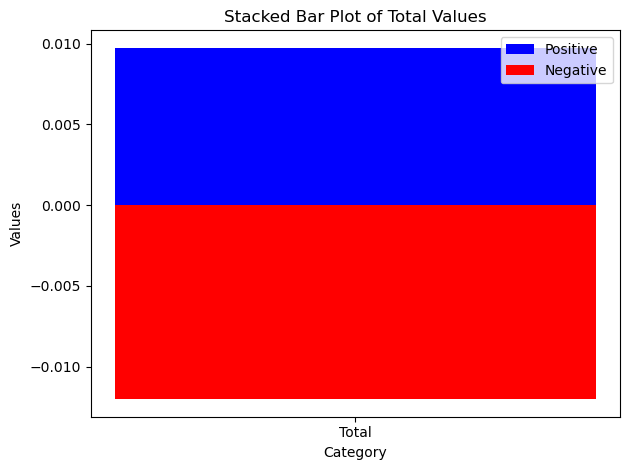

In [69]:
# Data provided by the user
data = {
    "Variable": ["num_a1", "num_a2", "num_a3", "num_a4", "num_c1", "num_c2", "num_c3", "num_c4"],
    "Value": cdatadiff.iloc[0][:-1].astype(float).tolist()
}

# Creating DataFrame
df = pd.DataFrame(data)

# Assigning positive and negative values to different series for stacked plot
df["Positive"] = df["Value"].apply(lambda x: x if x > 0 else 0)
df["Negative"] = df["Value"].apply(lambda x: x if x < 0 else 0)

# Summing positive and negative values
positive_sum = df["Positive"].sum()
negative_sum = df["Negative"].sum()

# Creating a new DataFrame for the stacked bar
stacked_data = {
    "Category": ["Positive", "Negative"],
    "Value": [positive_sum, negative_sum]
}

stacked_df = pd.DataFrame(stacked_data)

# Plotting stacked bar plot
fig, ax = plt.subplots()

# Plotting the stacked bar
ax.bar("Total", stacked_df["Value"], color=['b', 'r'], label=stacked_df["Category"])

# Adding labels and title
ax.set_xlabel("Category")
ax.set_ylabel("Values")
ax.set_title("Stacked Bar Plot of Total Values")
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [302]:
cdatadiff = cdatase[cdatase.columns[1:]] - cdatadef[cdatase.columns[1:]]
aa = cdatadiff[["num_a1", "num_a2", "num_a3", "num_a4", "num_c1", "num_c2", "num_c3", "num_c4"]]

aa.iloc[4].astype(float)#.plot(kind='bar', stacked=True)


num_a1   8.64608e-09
num_a2           NaN
num_a3           NaN
num_a4   7.13611e-07
num_c1           NaN
num_c2           NaN
num_c3           NaN
num_c4           NaN
Name: elevated emission, dtype: float64

In [303]:
cdatase

season  year       num_a1       num_a2  \
Burden (#/mg-air)                  ANN   NaN    0.0145034    0.0101508   
Sfc Conc. (#/cm3)                  ANN   NaN  1.81225e+19  9.22657e+18   
Sources (#/mg-air/yr)              ANN   NaN      1.00051       1.2012   
surface emission                   ANN   NaN  0.000153849    0.0333508   
elevated emission                  ANN   NaN   0.00192267          NaN   
Sinks (#/mg-air/yr)                ANN   NaN    -0.940219     -2.25334   
Dry deposition                     ANN   NaN    -0.374172    -0.640921   
gravitational                      ANN   NaN -0.000337113 -2.84757e-05   
turbulent                          ANN   NaN    -0.373835    -0.640892   
Wet deposition                     ANN   NaN    -0.276683  -0.00961893   
incloud, stratiform                ANN   NaN          NaN          NaN   
incloud, convective                ANN   NaN    -0.276484  -0.00907673   
belowcloud, strat.                 ANN   NaN -5.38613e-05 -0.000103822   
belowcloud, convec.                ANN   NaN -0.000144719 -0.000438378   
rain evap, strat.                  ANN   NaN          NaN          NaN   
rain evap, convec.                 ANN   NaN          NaN          NaN   
Lifetime (days)                    ANN   NaN      5.63033      1.64424   
renaming (sfgaex2)                 ANN   NaN    0.0519509   -0.0519509   
coagulation (sfcoag1)              ANN   NaN    -0.194169     -1.54866   
calcsize (sfcsiz3)                 ANN   NaN  2.41035e-07 -2.41035e-07   
calcsize (sfcsiz4)                 ANN   NaN -7.36257e-06  7.36257e-06   
dropmixnuc (mixnuc1)               ANN   NaN   -0.0951883  -0.00218853   
cloudchem (AQH2SO4)                ANN   NaN          NaN          NaN   
cloudchem (AQSO4)                  ANN   NaN          NaN          NaN   
condensation-aging                 ANN   NaN     0.946481          NaN   
sfnnuc1                            ANN   NaN          NaN      1.16784   
Aq. chem (gas-species)             ANN   NaN          NaN          NaN   
gas chem/wet dep. (gas-species)    ANN   NaN   0.00192791          NaN   

                                      num_a3       num_a4       num_c1  \
Burden (#/mg-air)                5.09988e-06   0.00394391  6.60509e-05   
Sfc Conc. (#/cm3)                5.15542e+15  3.91912e+19  4.70992e+16   
Sources (#/mg-air/yr)                      0      4.37163     0.095265   
surface emission                         NaN      4.07714          NaN   
elevated emission                        NaN      0.29449          NaN   
Sinks (#/mg-air/yr)              -0.00024632     -4.01814   -0.0957171   
Dry deposition                  -3.13468e-05     -2.67846  -0.00129097   
gravitational                   -1.03274e-05 -0.000338583 -0.000981148   
turbulent                       -2.10194e-05     -2.67812 -0.000309818   
Wet deposition                  -0.000143678 -8.24787e-05   -0.0944259   
incloud, stratiform                      NaN          NaN   -0.0944259   
incloud, convective             -0.000125776 -3.15977e-19          NaN   
belowcloud, strat.               -7.3903e-06 -3.88307e-05 -2.36724e-43   
belowcloud, convec.             -1.05115e-05  -4.3648e-05          NaN   
rain evap, strat.                9.77149e-06          NaN          NaN   
rain evap, convec.               1.05166e-06          NaN          NaN   
Lifetime (days)                      7.55708     0.358257     0.251873   
renaming (sfgaex2)                       NaN          NaN  7.67629e-05   
coagulation (sfcoag1)                    NaN    -0.393114          NaN   
calcsize (sfcsiz3)                       NaN          NaN          NaN   
calcsize (sfcsiz4)                       NaN          NaN -2.48925e-07   
dropmixnuc (mixnuc1)            -7.12951e-05   5.8338e-17    0.0951883   
cloudchem (AQH2SO4)                      NaN          NaN          NaN   
cloudchem (AQSO4)                        NaN          NaN          NaN   
condensation-aging                 

In [181]:
r = [0,1,2,3,4]
raw_data = {'num_a1': aa.loc[ll]['num_a1'].astype(float), \
            'num_a2': aa.loc[ll]['num_a2'].astype(float),\
            'num_a3': aa.loc[ll]['num_a3'].astype(float),\
            'num_a4': aa.loc[ll]['num_a4'].astype(float)}
df = pd.DataFrame(raw_data)

# From raw value to percentage
totals = [np.nansum([i,j,k,l]) for i,j,k,l in zip(df['num_a1'], df['num_a2'], df['num_a3'],df['num_a4'])]

In [49]:
cdatadef = get_tables(dfile,'num',reg=None,loc='SGP',mod='eam',indl=None,land=False)
pd.options.display.float_format = '{:g}'.format
cdatadef = cdatadef.applymap(lambda x: rounding(x))
cdatadef = cdatadef.astype(str)
cdatadef

/tmp/ipykernel_1509818/1617653827.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cdatadef = cdatadef.applymap(lambda x: rounding(x))


season year    num_a1    num_a2    num_a3  \
Burden (#/mg-air)                    -    -    0.0077     0.022     5e-06   
Sfc Conc. (#/cm3)                    -    -     6e+18     3e+19     5e+15   
Sources (#/mg-air/yr)                -    -     0.331     3.459     0e+00   
surface emission                     -    -   0.00015     0.033         -   
elevated emission                    -    -    0.0019         -         -   
Sinks (#/mg-air/yr)                  -    -    -0.336   -5.0055  -0.00024   
Dry deposition                       -    -    -0.093    -1.824    -3e-05   
gravitational                        -    -  -0.00018    -8e-05    -1e-05   
turbulent                            -    -    -0.093    -1.824    -2e-05   
Wet deposition                       -    -    -0.140    -0.026  -0.00014   
incloud, stratiform                  -    -         -         -         -   
incloud, convective                  -    -    -0.140    -0.025  -0.00012   
belowcloud, strat.                   -    -    -2e-05  -0.00024    -7e-06   
belowcloud, convec.                  -    -    -8e-05  -0.00089    -1e-05   
rain evap, strat.                    -    -         -         -     1e-05   
rain evap, convec.                   -    -         -         -     1e-06   
Lifetime (days)                      -    -     8.429     1.651     7.615   
renaming (sfgaex2)                   -    -     0.155    -0.155         -   
coagulation (sfcoag1)                -    -    -0.044    -2.994         -   
calcsize (sfcsiz3)                   -    -     5e-06    -5e-06         -   
calcsize (sfcsiz4)                   -    -    -2e-06     2e-06         -   
dropmixnuc (mixnuc1)                 -    -    -0.057   -0.0043    -7e-05   
cloudchem (AQH2SO4)                  -    -         -         -         -   
cloudchem (AQSO4)                    -    -         -         -         -   
condensation-aging                   -    -     0.174         -         -   
sfnnuc1                              -    -         -     3.426         -   
Aq. chem (gas-species)               -    -         -         -         -   
gas chem/wet dep. (gas-species)      -    -    0.0019         -         -   

                                  num_a4    num_c1    num_c2  num_c3  num_c4  \
Burden (#/mg-air)                0.00089     4e-05     2e-06   5e-08   2e-22   
Sfc Conc. (#/cm3)                  4e+18     3e+16     2e+15   3e+13       -   
Sources (#/mg-air/yr)              0.511     0.058    0.0043   7e-05   0e+00   
surface emission                   0.216         -         -       -       -   
elevated emission                  0.294         -         -       -       -   
Sinks (#/mg-air/yr)               -0.322    -0.058   -0.0043  -7e-05  -4e-18   
Dry deposition                    -0.128  -0.00073    -5e-05  -8e-07       -   
gravitational                     -7e-05  -0.00055    -3e-05  -6e-07       -   
turbulent                         -0.128  -0.00018    -1e-05  -2e-07       -   
Wet deposition                    -9e-06    -0.057   -0.0037  -7e-05  -1e-18   
incloud, stratiform                    -    -0.057   -0.0037  -7e-05  -1e-18   
incloud, convective               -3e-20         -         -       -       -   
belowcloud, strat.                -4e-06    -2e-43    -3e-43  -4e-43  -3e-42   
belowcloud, convec.               -5e-06         -         -       -       -   
rain evap, strat.                      -         -         -       -       -   
rain evap, convec.                     -         -         -       -       -   
Lifetime (days)                   1.0099     0.250     0.201   0.258   0.020   
renaming (sfgaex2)                     -   0.00053  -0.00053       -       -   
coagulation (sfcoag1)             -0.020         -         -       -       -   
calcsize (sfcsiz3)                     -     4e-07    -4e-07       -       -   
calcsize (sfcsiz4)                     -         -         -       -       -   
dropmixnuc (mixnuc1)               9e-

In [43]:
cdatadiff = cdatase[cdatase.columns[1:]] - cdatadef[cdatase.columns[1:]]
cdatarel = (cdatadiff/abs(cdatadef[cdatase.columns[1:]]))*100
pd.options.display.float_format = '{:g}'.format
cdatarel = cdatarel.applymap(lambda x: rounding(x))
cdatarel = cdatarel.astype(str)
cdatarel

/tmp/ipykernel_1509818/2521682452.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cdatarel = cdatarel.applymap(lambda x: rounding(x))


year     num_a1   num_a2  num_a3     num_a4  \
Burden (#/mg-air)                  -     86.591  -55.173  -1.578    342.045   
Sfc Conc. (#/cm3)                  -    220.292  -67.798  -0.906    846.168   
Sources (#/mg-air/yr)              -    202.028  -65.282       -    754.794   
surface emission                   -    0.00039  0.00039       -   1779.422   
elevated emission                  -    0.00045        -       -    0.00024   
Sinks (#/mg-air/yr)                -   -179.341   54.982   0.815  -1146.122   
Dry deposition                     -  -301.0041   64.877   1.279  -1986.807   
gravitational                      -    -82.607   66.412  -1.175   -390.617   
turbulent                          -   -301.437   64.877   2.442  -1987.665   
Wet deposition                     -    -96.572   63.372   2.025   -834.944   
incloud, stratiform                -          -        -       -          -   
incloud, convective                -    -96.572   63.873   2.211   -833.013   
belowcloud, strat.                 -   -123.426   57.091  -2.400   -959.531   
belowcloud, convec.                -    -87.433   51.019   2.768   -746.402   
rain evap, strat.                  -          -        -  -2.977          -   
rain evap, convec.                 -          -        -  -1.238          -   
Lifetime (days)                    -    -33.203   -0.423  -0.769    -64.526   
renaming (sfgaex2)                 -    -66.505   66.505       -          -   
coagulation (sfcoag1)              -   -333.570   48.291       -  -1864.545   
calcsize (sfcsiz3)                 -    -95.377   95.377       -          -   
calcsize (sfcsiz4)                 -   -303.225  303.225       -          -   
dropmixnuc (mixnuc1)               -    -64.867   49.798  -1.933    547.027   
cloudchem (AQH2SO4)                -          -        -       -          -   
cloudchem (AQSO4)                  -          -        -       -          -   
condensation-aging                 -    443.704        -       -   -443.704   
sfnnuc1                            -          -  -65.918       -          -   
Aq. chem (gas-species)             -          -        -       -          -   
gas chem/wet dep. (gas-species)    -     0.0011        -       -     0.0022   

                                  num_c1   num_c2   num_c3     num_c4  \
Burden (#/mg-air)                 64.682  -70.428    2.124   9470.424   
Sfc Conc. (#/cm3)                 76.610  -73.432  -17.350          -   
Sources (#/mg-air/yr)             63.477  -49.793    1.933          -   
surface emission                       -        -        -          -   
elevated emission                      -        -        -          -   
Sinks (#/mg-air/yr)              -63.732   49.835   -1.865  -3520.375   
Dry deposition                   -76.826   73.387   19.170          -   
gravitational                    -78.359   73.464   15.923          -   
turbulent                        -72.140   73.181   29.321          -   
Wet deposition                   -63.566   44.441   -2.101  -7416.821   
incloud, stratiform              -63.566   44.441   -2.101  -7416.821   
incloud, convective                    -        -        -          -   
belowcloud, strat.                -5.319    0.931    3.197   -112.997   
belowcloud, convec.                    -        -        -          -   
rain evap, strat.                      -        -        -          -   
rain evap, convec.                     -        -        -          -   
Lifetime (days)                    0.579  -41.050    0.254    164.348   
renaming (sfgaex2)               -85.719   85.719        -          -   
coagulation (sfcoag1)                  -        -        -          -   
calcsize (sfcsiz3)                     -        -        -          -   
calcsize (sfcsiz4)                     -        -        -          -   
dropmixnuc (mixnuc1)              64.867  -49.798    1.933  -1464.735   
cloudchem (AQH2SO4)                    -        -        -   

/tmp/ipykernel_31103/694749544.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[np.sign(cdatase.loc[categories][nn][i])] if not np.isnan(cdatase.loc[categories][nn][i]) else ''
/tmp/ipykernel_31103/694749544.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[np.sign(cdatase.loc[categories][nn][i])] if not np.isnan(cdatase.loc[categories][nn][i]) else ''
/tmp/ipykernel_31103/694749544.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavi

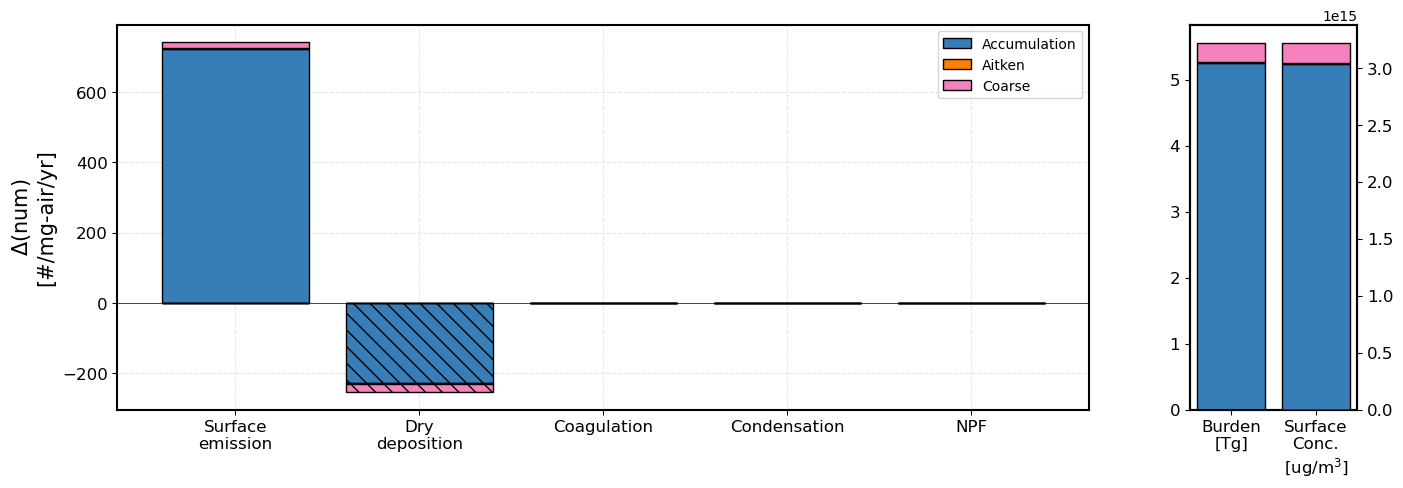

In [22]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

#calculator = AerosolBudgetCalculator(path='/global/cfs/projectdirs/m3525/mhass004/clim_out/', \
#                                     case='SSA10xPD', ts='ANN', aer='ncl',reg='Global')
#cdatase = calculator.get_tables()
#calculator = AerosolBudgetCalculator(path='/global/cfs/projectdirs/m3525/mhass004/clim_out/', \
#                                     case='AS_Total', ts='ANN', aer='ncl',reg='Global')
#cdatadef = calculator.get_tables()
#cdatadiff = cdatase[cdatase.columns[1:]] - cdatadef[cdatase.columns[1:]]

# Prepare data
avals = cdatadiff[["ncl_a1", "ncl_a2", "ncl_a3"]]
cvals = cdatadiff[["ncl_c1", "ncl_c2", "ncl_c3"]]
cvals.columns = ["ncl_a1", "ncl_a2", "ncl_a3"]
aa = avals.fillna(0) + cvals.fillna(0)

# Plot settings
categories = ['surface emission', 'Dry deposition', 'coagulation (sfcoag1)', 'condensation-aging', 'sfnnuc1']
labels = ['Surface\nemission', 'Dry\ndeposition', 'Coagulation', 'Condensation', 'NPF']
barWidth = 0.85
colors = ['#377eb8', '#ff7f00', '#f781bf', '#a65628']
modes = ['Accumulation', 'Aitken', 'Coarse', 'Primary-carbon']
hatches = {1: '', -1: '\\\\'}

# Initialize plot
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, wspace=0.6)
ax1 = fig.add_subplot(gs[:, :4])

# Initialize the bottom arrays for positive and negative values
oldvals_pos = np.zeros(len(categories))
oldvals_neg = np.zeros(len(categories))

# Plot bars
for nn, color, mode in zip(["ncl_a1", "ncl_a2", "ncl_a3"], colors, modes):
    vals = aa.loc[categories][nn].astype(float)
    pos_vals = np.where(vals > 0, vals, 0)
    neg_vals = np.where(vals < 0, vals, 0)

    for i in range(len(categories)):
        hatch_pattern = hatches[np.sign(cdatase.loc[categories][nn][i])] if not np.isnan(cdatase.loc[categories][nn][i]) else ''
        ax1.bar(i, pos_vals[i], edgecolor='k', zorder=4, bottom=oldvals_pos[i], color=color, hatch=hatch_pattern, label=f'{mode}' if i == 0 else "")
        ax1.bar(i, neg_vals[i], edgecolor='k', zorder=4, bottom=oldvals_neg[i], color=color, hatch=hatch_pattern)

    oldvals_pos += pos_vals
    oldvals_neg += neg_vals

ax1.axhline(0, color='black', linewidth=0.5, zorder=4)
ax1.set_ylabel('$\Delta$(num)\n[#/mg-air/yr]', fontsize=15)
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels)
ax1.legend(loc='upper right')
ax1.grid(linestyle='--', color='#EBE7E0', zorder=3)

# Secondary plot
categories_secondary = ['Burden (Tg)', 'Sfc Conc. (ug/m3)']
labels_secondary = ['Burden\n[Tg]', 'Surface\nConc.\n[ug/m$^3$]']
oldvals_pos = np.zeros(len(categories_secondary))
oldvals_neg = np.zeros(len(categories_secondary))
ax2 = fig.add_subplot(gs[:, 4:])
ax3 = ax2.twinx()

# Find limits for secondary plot
bmax, cmax = aa.loc[categories_secondary][["ncl_a1", "ncl_a2", "ncl_a3"]].astype(float).max(axis=1)
bmin, cmin = aa.loc[categories_secondary][["ncl_a1", "ncl_a2", "ncl_a3"]].astype(float).min(axis=1)

for nn, color, mode in zip(["ncl_a1", "ncl_a2", "ncl_a3"], colors, modes):
    vals = aa.loc[categories_secondary][nn].astype(float)
    pos_vals = np.where(vals > 0, vals, 0)
    neg_vals = np.where(vals < 0, vals, 0)

    for i in range(len(categories_secondary)):
        if i == 1:
            ax3.bar(i, pos_vals[i], edgecolor='k', zorder=4, bottom=oldvals_pos[i], color=color, hatch=hatch_pattern)
            ax3.bar(i, neg_vals[i], edgecolor='k', zorder=4, bottom=oldvals_neg[i], color=color, hatch=hatch_pattern)
        else:
            hatch_pattern = hatches[np.sign(cdatase.loc[categories_secondary][nn][i])] if not np.isnan(cdatase.loc[categories_secondary][nn][i]) else ''
            ax2.bar(i, pos_vals[i], edgecolor='k', zorder=4, bottom=oldvals_pos[i], color=color, hatch=hatch_pattern)
            ax2.bar(i, neg_vals[i], edgecolor='k', zorder=4, bottom=oldvals_neg[i], color=color, hatch=hatch_pattern)

    oldvals_pos += pos_vals
    oldvals_neg += neg_vals

#ax2.set_ylim([bmin, bmax])
#ax3.set_ylim([cmin, cmax])
ax2.set_xticks(np.arange(len(labels_secondary)))
ax2.set_xticklabels(labels_secondary)
plt.setp(ax1.spines.values(), lw=1.5)
plt.setp(ax2.spines.values(), lw=1.5)
plt.setp(ax3.spines.values(), lw=1.5)
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax3.tick_params(labelsize=12)

plt.tight_layout()


In [23]:
cdatadiff

year        ncl_a1        ncl_a2  \
Burden (Tg)                       NaN  5.003757e+00  1.409868e-02   
Sfc Conc. (ug/m3)                 NaN  3.018349e+15  7.776786e+12   
Sources (Tg/yr)                   NaN  7.218728e+02  4.419744e+00   
surface emission                  NaN  7.211856e+02  4.419745e+00   
elevated emission                 NaN           NaN           NaN   
Sinks (Tg/yr)                     NaN -7.282357e+02 -4.448596e+00   
Dry deposition                    NaN -2.225130e+02 -2.929944e+00   
gravitational                     NaN -1.156630e+01 -1.434984e-03   
turbulent                         NaN -2.109467e+02 -2.928509e+00   
Wet deposition                    NaN -1.749214e+02 -2.079833e-01   
incloud, stratiform               NaN           NaN           NaN   
incloud, convective               NaN -1.667414e+02 -2.078132e-01   
belowcloud, strat.                NaN -3.885989e+00 -1.220318e-04   
belowcloud, convec.               NaN -4.294034e+00 -4.802925e-05   
rain evap, strat.                 NaN  6.209398e-02  1.546814e-06   
rain evap, convec.                NaN  3.584279e+00  3.533858e-03   
Lifetime (days)                   NaN  4.812407e-02  5.383607e-01   
renaming (sfgaex2)                NaN  5.276581e-01 -5.276581e-01   
coagulation (sfcoag1)             NaN  1.592557e-01 -1.592557e-01   
calcsize (sfcsiz3)                NaN  2.481703e-04 -2.481703e-04   
calcsize (sfcsiz4)                NaN  1.286406e-06 -1.286406e-06   
dropmixnuc (mixnuc1)              NaN -3.308013e+02 -6.235066e-01   
cloudchem (AQH2SO4)               NaN           NaN           NaN   
cloudchem (AQSO4)                 NaN           NaN           NaN   
condensation-aging                NaN           NaN           NaN   
sfnnuc1                           NaN           NaN           NaN   
Aq. chem (gas-species)            NaN           NaN           NaN   
gas chem/wet dep. (gas-species)   NaN           NaN           NaN   

                                       ncl_a3        ncl_c1        ncl_c2  \
Burden (Tg)                      2.656349e-01  2.488234e-01  3.427029e-04   
Sfc Conc. (ug/m3)                1.808735e+14  1.597313e+13  1.956003e+10   
Sources (Tg/yr)                  1.682084e+01  3.308415e+02  6.235066e-01   
surface emission                 1.682084e+01           NaN           NaN   
elevated emission                         NaN           NaN           NaN   
Sinks (Tg/yr)                   -1.695969e+01 -3.309080e+02 -6.239296e-01   
Dry deposition                  -2.473285e+01 -3.710725e+00 -5.147144e-03   
gravitational                   -1.387398e+01 -3.064284e+00 -3.782221e-03   
turbulent                       -1.085888e+01 -6.464419e-01 -1.364923e-03   
Wet deposition                  -1.156337e+00 -3.271972e+02 -5.785661e-01   
incloud, stratiform                       NaN -3.271972e+02 -5.785661e-01   
incloud, convective             -8.308122e+00           NaN           NaN   
belowcloud, strat.              -5.306347e+00  5.887867e-22  2.595901e-21   
belowcloud, convec.             -8.779766e-01           NaN           NaN   
rain evap, strat.               -1.713680e-01  1.692899e+01  1.553344e-02   
rain evap, convec.               1.353900e-01           NaN           NaN   
Lifetime (days)                  3.564716e-02  3.777046e-02  6.412367e-02   
renaming (sfgaex2)                        NaN  4.019240e-02 -4.019240e-02   
coagulation (sfcoag1)                     NaN           NaN           NaN   
calcsize (sfcsiz3)                        NaN  2.401283e-05 -2.401283e-05   
calcsize (sfcsiz4)                        NaN  5.826019e-10 -5.826019e-10   
dropmixnuc (mixnuc1)             8.929497e+00  3.308013e+02  6.235066e-01   
cloudchem (AQH2SO4)                       NaN           NaN           NaN   
cloudchem (AQSO4)                         NaN           NaN           NaN   
condensation-aging                        NaN           NaN           NaN   
sfnnuc1                      

/tmp/ipykernel_921493/2621418614.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[np.sign(cdatase.loc[categories][nn][i])] if not np.isnan(cdatase.loc[categories][nn][i]) else ''
/tmp/ipykernel_921493/2621418614.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[np.sign(cdatase.loc[categories][nn][i])] if not np.isnan(cdatase.loc[categories][nn][i]) else ''
/tmp/ipykernel_921493/2621418614.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

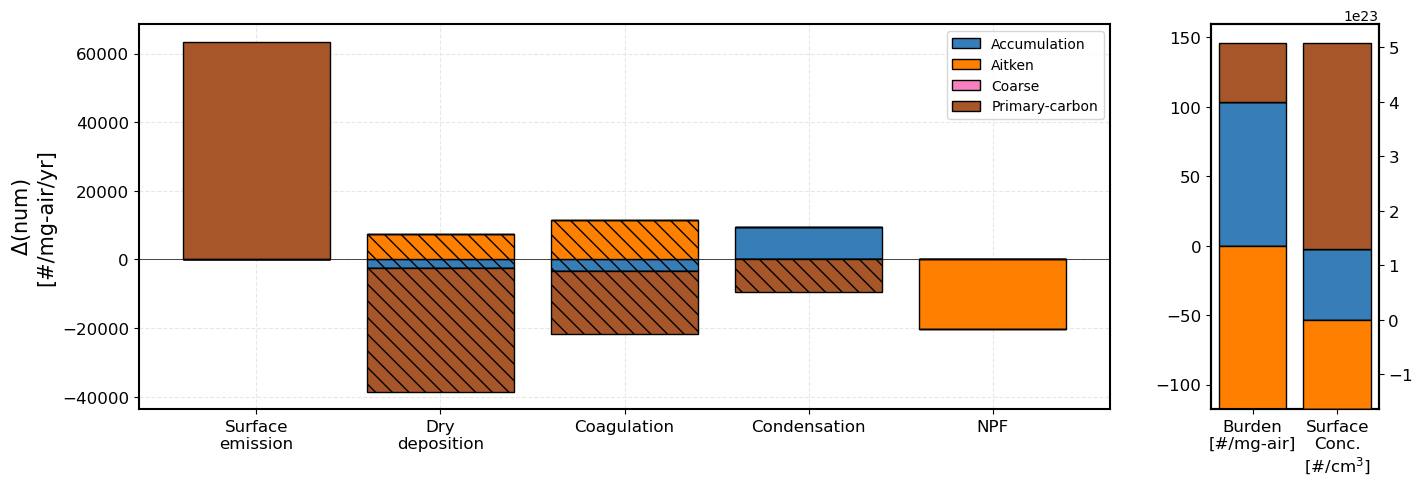

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Load data (assuming get_tables is defined elsewhere)
dfile = 'F20TR_2016Emis_ne30pg2_control.eam.ANN.2016_climo.nc'
pfile = 'F20TR_2016Emis_ne30pg2_highUB.eam.ANN.2016_climo.nc'
#cdatadef = get_tables(dfile, 'num', reg=None, loc='SGP', mod='eam', indl=None, land=False)
#cdatase = get_tables(pfile, 'num', reg=None, loc='SGP', mod='eam', indl=None, land=False)
cdatadef = get_tables(dfile, 'num', reg='Global', loc=None, mod='eam', indl=None, land=False)
cdatase = get_tables(pfile, 'num', reg='Global', loc=None, mod='eam', indl=None, land=False)
cdatadiff = cdatase[cdatase.columns[1:]] - cdatadef[cdatase.columns[1:]]

# Prepare data
avals = cdatadiff[["num_a1", "num_a2", "num_a3", "num_a4"]]
cvals = cdatadiff[["num_c1", "num_c2", "num_c3", "num_c4"]]
cvals.columns = ["num_a1", "num_a2", "num_a3", "num_a4"]
aa = avals.fillna(0) + cvals.fillna(0)

# Plot settings
categories = ['surface emission', 'Dry deposition', 'coagulation (sfcoag1)', 'condensation-aging', 'sfnnuc1']
labels = ['Surface\nemission', 'Dry\ndeposition', 'Coagulation', 'Condensation', 'NPF']
barWidth = 0.85
colors = ['#377eb8', '#ff7f00', '#f781bf', '#a65628']
modes = ['Accumulation', 'Aitken', 'Coarse', 'Primary-carbon']
hatches = {1: '', -1: '\\\\'}

# Initialize plot
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, wspace=0.6)
ax1 = fig.add_subplot(gs[:, :4])

# Initialize the bottom arrays for positive and negative values
oldvals_pos = np.zeros(len(categories))
oldvals_neg = np.zeros(len(categories))

# Plot bars
for nn, color, mode in zip(["num_a1", "num_a2", "num_a3", "num_a4"], colors, modes):
    vals = aa.loc[categories][nn].astype(float)
    pos_vals = np.where(vals > 0, vals, 0)
    neg_vals = np.where(vals < 0, vals, 0)

    for i in range(len(categories)):
        hatch_pattern = hatches[np.sign(cdatase.loc[categories][nn][i])] if not np.isnan(cdatase.loc[categories][nn][i]) else ''
        ax1.bar(i, pos_vals[i], edgecolor='k', zorder=4, bottom=oldvals_pos[i], color=color, hatch=hatch_pattern, label=f'{mode}' if i == 0 else "")
        ax1.bar(i, neg_vals[i], edgecolor='k', zorder=4, bottom=oldvals_neg[i], color=color, hatch=hatch_pattern)

    oldvals_pos += pos_vals
    oldvals_neg += neg_vals

ax1.axhline(0, color='black', linewidth=0.5, zorder=4)
ax1.set_ylabel('$\Delta$(num)\n[#/mg-air/yr]', fontsize=15)
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels)
ax1.legend(loc='upper right')
ax1.grid(linestyle='--', color='#EBE7E0', zorder=3)

# Secondary plot
categories_secondary = ['Burden (#/mg-air)', 'Sfc Conc. (#/cm3)']
labels_secondary = ['Burden\n[#/mg-air]', 'Surface\nConc.\n[#/cm$^3$]']
oldvals_pos = np.zeros(len(categories_secondary))
oldvals_neg = np.zeros(len(categories_secondary))
ax2 = fig.add_subplot(gs[:, 4:])
ax3 = ax2.twinx()

# Find limits for secondary plot
bmax, cmax = aa.loc[categories_secondary][['num_a1', 'num_a2', 'num_a3', 'num_a4']].astype(float).max(axis=1)
bmin, cmin = aa.loc[categories_secondary][['num_a1', 'num_a2', 'num_a3', 'num_a4']].astype(float).min(axis=1)

for nn, color, mode in zip(["num_a1", "num_a2", "num_a3", "num_a4"], colors, modes):
    vals = aa.loc[categories_secondary][nn].astype(float)
    pos_vals = np.where(vals > 0, vals, 0)
    neg_vals = np.where(vals < 0, vals, 0)

    for i in range(len(categories_secondary)):
        if i == 1:
            ax3.bar(i, pos_vals[i], edgecolor='k', zorder=4, bottom=oldvals_pos[i], color=color, hatch=hatch_pattern)
            ax3.bar(i, neg_vals[i], edgecolor='k', zorder=4, bottom=oldvals_neg[i], color=color, hatch=hatch_pattern)
        else:
            hatch_pattern = hatches[np.sign(cdatase.loc[categories_secondary][nn][i])] if not np.isnan(cdatase.loc[categories_secondary][nn][i]) else ''
            ax2.bar(i, pos_vals[i], edgecolor='k', zorder=4, bottom=oldvals_pos[i], color=color, hatch=hatch_pattern)
            ax2.bar(i, neg_vals[i], edgecolor='k', zorder=4, bottom=oldvals_neg[i], color=color, hatch=hatch_pattern)

    oldvals_pos += pos_vals
    oldvals_neg += neg_vals

#ax2.set_ylim([bmin, bmax])
#ax3.set_ylim([cmin, cmax])
ax2.set_xticks(np.arange(len(labels_secondary)))
ax2.set_xticklabels(labels_secondary)
plt.setp(ax1.spines.values(), lw=1.5)
plt.setp(ax2.spines.values(), lw=1.5)
plt.setp(ax3.spines.values(), lw=1.5)
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax3.tick_params(labelsize=12)

plt.tight_layout()


In [6]:
# Load data (assuming get_tables is defined elsewhere)
dfile = 'F20TR_2016Emis_ne30pg2_control.eam.ANN.2016_climo.nc'
pfile = 'F20TR_2016Emis_ne30pg2_highUB.eam.ANN.2016_climo.nc'
cdatadef = get_tables(dfile, 'H2SO4', reg=None, loc='SGP', mod='eam', indl=None, land=False)
cdatase = get_tables(pfile, 'H2SO4', reg=None, loc='SGP', mod='eam', indl=None, land=False)
cdatadiff = cdatase[cdatase.columns[1:]] - cdatadef[cdatase.columns[1:]]
cdatadiff

year         H2SO4   total_H2SO4
Burden (TgS)                      NaN -3.953674e-10 -3.953674e-10
Sfc Conc. (ug/m3)                 NaN -1.077133e+06 -1.077133e+06
Sources (TgS/yr)                  NaN -1.060671e-05 -1.060671e-05
surface emission                  NaN           NaN           NaN
elevated emission                 NaN           NaN           NaN
Sinks (TgS/yr)                    NaN  1.096647e-05  1.096647e-05
Dry deposition                    NaN  2.966572e-07  2.966572e-07
gravitational                     NaN           NaN           NaN
turbulent                         NaN           NaN           NaN
Wet deposition                    NaN  2.134306e-08  2.134306e-08
incloud, stratiform               NaN           NaN           NaN
incloud, convective               NaN           NaN           NaN
belowcloud, strat.                NaN           NaN           NaN
belowcloud, convec.               NaN           NaN           NaN
rain evap, strat.                 NaN           NaN           NaN
rain evap, convec.                NaN           NaN           NaN
Lifetime (days)                   NaN -2.631487e-04 -2.631487e-04
renaming (sfgaex2)                NaN           NaN           NaN
coagulation (sfcoag1)             NaN           NaN           NaN
calcsize (sfcsiz3)                NaN           NaN           NaN
calcsize (sfcsiz4)                NaN           NaN           NaN
dropmixnuc (mixnuc1)              NaN           NaN           NaN
cloudchem (AQH2SO4)               NaN           NaN           NaN
cloudchem (AQSO4)                 NaN           NaN           NaN
condensation-aging                NaN  4.650965e-06  4.650965e-06
sfnnuc1                           NaN  5.906526e-06  5.906526e-06
Aq. chem (gas-species)            NaN  9.098061e-08  9.098061e-08
gas chem/wet dep. (gas-species)   NaN -1.060671e-05 -1.060671e-05

In [9]:
df

Control Case Test Case difference rel diff (%)
Burden (TgS)                           3e-09     2e-09     -4e-10      -13.959
Sfc Conc. (ug/m3)                      5e+06     4e+06     -1e+06      -20.439
Sources (TgS/yr)                     0.00046   0.00045     -1e-05       -2.287
surface emission                           -         -          -            -
elevated emission                          -         -          -            -
Sinks (TgS/yr)                      -0.00046  -0.00045      1e-05        2.347
Dry deposition                        -2e-06    -2e-06      3e-07       14.643
gravitational                              -         -          -            -
turbulent                                  -         -          -            -
Wet deposition                        -6e-07    -6e-07      2e-08        3.584
incloud, stratiform                        -         -          -            -
incloud, convective                        -         -          -            -
belowcloud, strat.                         -         -          -            -
belowcloud, convec.                        -         -          -            -
rain evap, strat.                          -         -          -            -
rain evap, convec.                         -         -          -            -
Lifetime (days)                       0.0022    0.0019   -0.00026      -11.891
renaming (sfgaex2)                         -         -          -            -
coagulation (sfcoag1)                      -         -          -            -
calcsize (sfcsiz3)                         -         -          -            -
calcsize (sfcsiz4)                         -         -          -            -
dropmixnuc (mixnuc1)                       -         -          -            -
cloudchem (AQH2SO4)                        -         -          -            -
cloudchem (AQSO4)                          -         -          -            -
condensation-aging                  -0.00044  -0.00043      5e-06        1.052
sfnnuc1                               -9e-06    -3e-06      6e-06       65.918
Aq. chem (gas-species)                -1e-05    -1e-05      9e-08        0.674
gas chem/wet dep. (gas-species)      0.00046   0.00045     -1e-05       -2.287

/tmp/ipykernel_941338/4028508988.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[np.sign(cdatase.loc[categories][nn][i])] if not np.isnan(cdatase.loc[categories][nn][i]) else ''
/tmp/ipykernel_941338/4028508988.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[np.sign(cdatase.loc[categories][nn][i])] if not np.isnan(cdatase.loc[categories][nn][i]) else ''
/tmp/ipykernel_941338/4028508988.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

Burden (#/mg-air)   0.00768611
Sfc Conc. (#/cm3)   2.1402e+19
Name: num_a1, dtype: float64
Burden (#/mg-air)    -0.00128099
Sfc Conc. (#/cm3)   -3.39216e+17
Name: num_a2, dtype: float64
Burden (#/mg-air)   -5.43562e-08
Sfc Conc. (#/cm3)    5.33864e+13
Name: num_a3, dtype: float64
Burden (#/mg-air)    0.00208549
Sfc Conc. (#/cm3)   6.08792e+19
Name: num_a4, dtype: float64


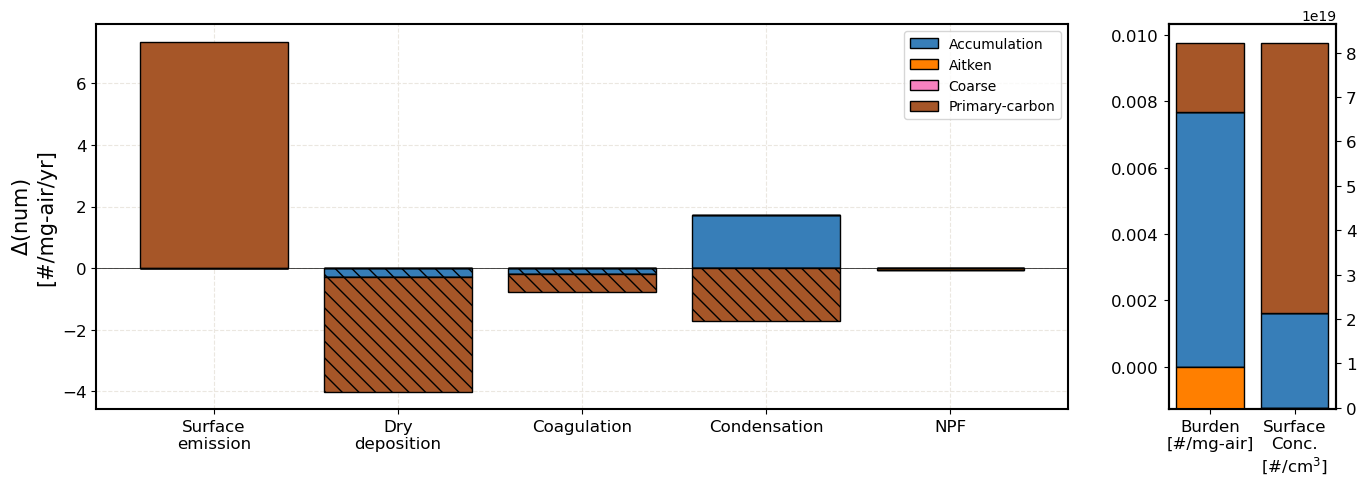

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Load data (assuming get_tables is defined elsewhere)
dfile = 'F20TR_2016Emis_ne30pg2_control.eam.ANN.2016_climo.nc'
pfile = 'F20TR_2016Emis_ne30pg2_highUB.eam.ANN.2016_climo.nc'
cdatadef = get_tables(dfile, 'num', reg=None, loc='GoAmazon', mod='eam', indl=None, land=False)
cdatase = get_tables(pfile, 'num', reg=None, loc='GoAmazon', mod='eam', indl=None, land=False)
cdatadiff = cdatase[cdatase.columns[1:]] - cdatadef[cdatase.columns[1:]]

# Prepare data
avals = cdatadiff[["num_a1", "num_a2", "num_a3", "num_a4"]]
cvals = cdatadiff[["num_c1", "num_c2", "num_c3", "num_c4"]]
cvals.columns = ["num_a1", "num_a2", "num_a3", "num_a4"]
aa = avals.fillna(0) + cvals.fillna(0)

# Plot settings
categories = ['surface emission', 'Dry deposition', 'coagulation (sfcoag1)', 'condensation-aging', 'sfnnuc1']
labels = ['Surface\nemission', 'Dry\ndeposition', 'Coagulation', 'Condensation', 'NPF']
barWidth = 0.85
colors = ['#377eb8', '#ff7f00', '#f781bf', '#a65628']
modes = ['Accumulation', 'Aitken', 'Coarse', 'Primary-carbon']
hatches = {1: '', -1: '\\\\'}

# Initialize plot
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, wspace=0.6)
ax1 = fig.add_subplot(gs[:, :4])

# Initialize the bottom arrays for positive and negative values
oldvals_pos = np.zeros(len(categories))
oldvals_neg = np.zeros(len(categories))

# Plot bars
for nn, color, mode in zip(["num_a1", "num_a2", "num_a3", "num_a4"], colors, modes):
    vals = aa.loc[categories][nn].astype(float)
    #print(vals)
    pos_vals = np.where(vals > 0, vals, 0)
    neg_vals = np.where(vals < 0, vals, 0)

    for i in range(len(categories)):
        hatch_pattern = hatches[np.sign(cdatase.loc[categories][nn][i])] if not np.isnan(cdatase.loc[categories][nn][i]) else ''
        ax1.bar(i, pos_vals[i], edgecolor='k', zorder=4, bottom=oldvals_pos[i], color=color, hatch=hatch_pattern, label=f'{mode}' if i == 0 else "")
        ax1.bar(i, neg_vals[i], edgecolor='k', zorder=4, bottom=oldvals_neg[i], color=color, hatch=hatch_pattern)

    oldvals_pos += pos_vals
    oldvals_neg += neg_vals

ax1.axhline(0, color='black', linewidth=0.5, zorder=4)
ax1.set_ylabel('$\Delta$(num)\n[#/mg-air/yr]', fontsize=15)
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels)
ax1.legend(loc='upper right')
ax1.grid(linestyle='--', color='#EBE7E0', zorder=3)

# Secondary plot
categories_secondary = ['Burden (#/mg-air)', 'Sfc Conc. (#/cm3)']
labels_secondary = ['Burden\n[#/mg-air]', 'Surface\nConc.\n[#/cm$^3$]']
oldvals_pos = np.zeros(len(categories_secondary))
oldvals_neg = np.zeros(len(categories_secondary))
ax2 = fig.add_subplot(gs[:, 4:])
ax3 = ax2.twinx()

# Find limits for secondary plot
bmax, cmax = aa.loc[categories_secondary][['num_a1', 'num_a2', 'num_a3', 'num_a4']].astype(float).max(axis=1)
bmin, cmin = aa.loc[categories_secondary][['num_a1', 'num_a2', 'num_a3', 'num_a4']].astype(float).min(axis=1)

for nn, color, mode in zip(["num_a1", "num_a2", "num_a3", "num_a4"], colors, modes):
    vals = aa.loc[categories_secondary][nn].astype(float)
    print(vals)
    pos_vals = np.where(vals > 0, vals, 0)
    neg_vals = np.where(vals < 0, vals, 0)

    for i in range(len(categories_secondary)):
        if i == 1:
            ax3.bar(i, pos_vals[i], edgecolor='k', zorder=4, bottom=oldvals_pos[i], color=color, hatch=hatch_pattern)
            ax3.bar(i, neg_vals[i], edgecolor='k', zorder=4, bottom=oldvals_neg[i], color=color, hatch=hatch_pattern)
        else:
            hatch_pattern = hatches[np.sign(cdatase.loc[categories_secondary][nn][i])] if not np.isnan(cdatase.loc[categories_secondary][nn][i]) else ''
            ax2.bar(i, pos_vals[i], edgecolor='k', zorder=4, bottom=oldvals_pos[i], color=color, hatch=hatch_pattern)
            ax2.bar(i, neg_vals[i], edgecolor='k', zorder=4, bottom=oldvals_neg[i], color=color, hatch=hatch_pattern)

    oldvals_pos += pos_vals
    oldvals_neg += neg_vals

#ax2.set_ylim([bmin, bmax])
#ax3.set_ylim([cmin, cmax])
ax2.set_xticks(np.arange(len(labels_secondary)))
ax2.set_xticklabels(labels_secondary)
plt.setp(ax1.spines.values(), lw=1.5)
plt.setp(ax2.spines.values(), lw=1.5)
plt.setp(ax3.spines.values(), lw=1.5)
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax3.tick_params(labelsize=12)

plt.tight_layout()


/tmp/ipykernel_1536461/3200689658.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[np.sign(cdatase.loc[categories][nn][i])] if not np.isnan(cdatase.loc[categories][nn][i]) else ''
/tmp/ipykernel_1536461/3200689658.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[np.sign(cdatase.loc[categories][nn][i])] if not np.isnan(cdatase.loc[categories][nn][i]) else ''
/tmp/ipykernel_1536461/3200689658.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

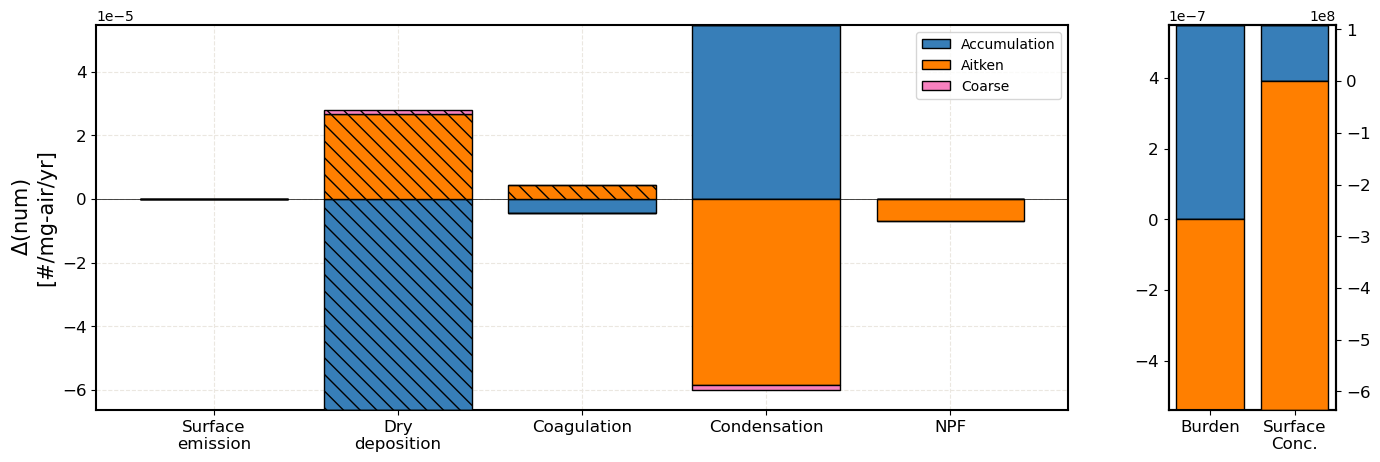

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Load data (assuming get_tables is defined elsewhere)
dfile = 'F20TR_2016Emis_ne30pg2_control.eam.ANN.2016_climo.nc'
pfile = 'F20TR_2016Emis_ne30pg2_highUB.eam.ANN.2016_climo.nc'
cdatadef = get_tables(dfile, 'so4', reg=None, loc='SGP', mod='eam', indl=None, land=False)
cdatase = get_tables(pfile, 'so4', reg=None, loc='SGP', mod='eam', indl=None, land=False)
cdatadiff = cdatase[cdatase.columns[1:]] - cdatadef[cdatase.columns[1:]]

# Prepare data
avals = cdatadiff[cdatadef.columns[2:-4]]
cvals = cdatadiff[cdatadef.columns[5:-1]]
cvals.columns = cdatadef.columns[2:-4]
aa = avals.fillna(0) + cvals.fillna(0)

# Plot settings
categories = ['surface emission', 'Dry deposition', 'coagulation (sfcoag1)', 'condensation-aging', 'sfnnuc1']
labels = ['Surface\nemission', 'Dry\ndeposition', 'Coagulation', 'Condensation', 'NPF']
barWidth = 0.85
colors = ['#377eb8', '#ff7f00', '#f781bf', '#a65628']
modes = ['Accumulation', 'Aitken', 'Coarse', 'Primary-carbon']
hatches = {1: '', -1: '\\\\'}

# Initialize plot
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, wspace=0.6)
ax1 = fig.add_subplot(gs[:, :4])

# Initialize the bottom arrays for positive and negative values
oldvals_pos = np.zeros(len(categories))
oldvals_neg = np.zeros(len(categories))

# Plot bars
for nn, color, mode in zip(cdatadef.columns[2:-4], colors, modes):
    vals = aa.loc[categories][nn].astype(float)
    pos_vals = np.where(vals > 0, vals, 0)
    neg_vals = np.where(vals < 0, vals, 0)

    for i in range(len(categories)):
        hatch_pattern = hatches[np.sign(cdatase.loc[categories][nn][i])] if not np.isnan(cdatase.loc[categories][nn][i]) else ''
        ax1.bar(i, pos_vals[i], edgecolor='k', zorder=4, bottom=oldvals_pos[i], color=color, hatch=hatch_pattern, label=f'{mode}' if i == 0 else "")
        ax1.bar(i, neg_vals[i], edgecolor='k', zorder=4, bottom=oldvals_neg[i], color=color, hatch=hatch_pattern)

    oldvals_pos += pos_vals
    oldvals_neg += neg_vals

ax1.axhline(0, color='black', linewidth=0.5, zorder=4)
ax1.set_ylabel('$\Delta$(num)\n[#/mg-air/yr]', fontsize=15)
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels)
ax1.legend(loc='upper right')
ax1.grid(linestyle='--', color='#EBE7E0', zorder=3)

# Secondary plot
categories_secondary = [cdatadef.index[0], cdatadef.index[1]]
labels_secondary = ['Burden', 'Surface\nConc.']
oldvals_pos = np.zeros(len(categories_secondary))
oldvals_neg = np.zeros(len(categories_secondary))
ax2 = fig.add_subplot(gs[:, 4:])
ax3 = ax2.twinx()

# Find limits for secondary plot
bmax, cmax = aa.loc[categories_secondary][cdatadef.columns[2:-4]].astype(float).max(axis=1)
bmin, cmin = aa.loc[categories_secondary][cdatadef.columns[2:-4]].astype(float).min(axis=1)

for nn, color, mode in zip(cdatadef.columns[2:-4], colors, modes):
    vals = aa.loc[categories_secondary][nn].astype(float)
    pos_vals = np.where(vals > 0, vals, 0)
    neg_vals = np.where(vals < 0, vals, 0)

    for i in range(len(categories_secondary)):
        if i == 1:
            ax3.bar(i, pos_vals[i], edgecolor='k', zorder=4, bottom=oldvals_pos[i], color=color, hatch=hatch_pattern)
            ax3.bar(i, neg_vals[i], edgecolor='k', zorder=4, bottom=oldvals_neg[i], color=color, hatch=hatch_pattern)
        else:
            hatch_pattern = hatches[np.sign(cdatase.loc[categories_secondary][nn][i])] if not np.isnan(cdatase.loc[categories_secondary][nn][i]) else ''
            ax2.bar(i, pos_vals[i], edgecolor='k', zorder=4, bottom=oldvals_pos[i], color=color, hatch=hatch_pattern)
            ax2.bar(i, neg_vals[i], edgecolor='k', zorder=4, bottom=oldvals_neg[i], color=color, hatch=hatch_pattern)

    oldvals_pos += pos_vals
    oldvals_neg += neg_vals

ax2.set_ylim([bmin, bmax])
ax3.set_ylim([cmin, cmax])
ax2.set_xticks(np.arange(len(labels_secondary)))
ax2.set_xticklabels(labels_secondary)
plt.setp(ax1.spines.values(), lw=1.5)
plt.setp(ax2.spines.values(), lw=1.5)
plt.setp(ax3.spines.values(), lw=1.5)
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax3.tick_params(labelsize=12)

plt.tight_layout()


In [20]:
dfile = 'F20TR_2016Emis_ne30pg2_control.eam.ANN.2016_climo.nc'
data = xr.open_mfdataset('/global/cfs/projectdirs/m3525/mhass004/clim_out/'+dfile)
lon = data['lon'].values
lon[lon > 180.] -= 360.
lat = data['lat']
data['EXTINCT']

<xarray.DataArray 'EXTINCT' (lev: 72, ncol: 21600)>
dask.array<open_dataset-EXTINCT, shape=(72, 21600), dtype=float64, chunksize=(72, 21600), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.1238 0.1828 0.2699 0.3986 ... 986.2 993.8 998.5
    year     int64 ...
Dimensions without coordinates: ncol

In [38]:
dfile = 'F20TR_2016Emis_ne30pg2_highUB.eam.ANN.2016_climo.nc'
data2 = xr.open_mfdataset('/global/cfs/projectdirs/m3525/mhass004/clim_out/'+dfile)
lon = data2['lon'].values
lon[lon > 180.] -= 360.
lat = data2['lat']

Cannot subscript Segmented Colormap!


/tmp/ipykernel_941338/1275294535.py:229: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  s2 = s1.applymap(lambda x: rounding(x))[0].tolist()


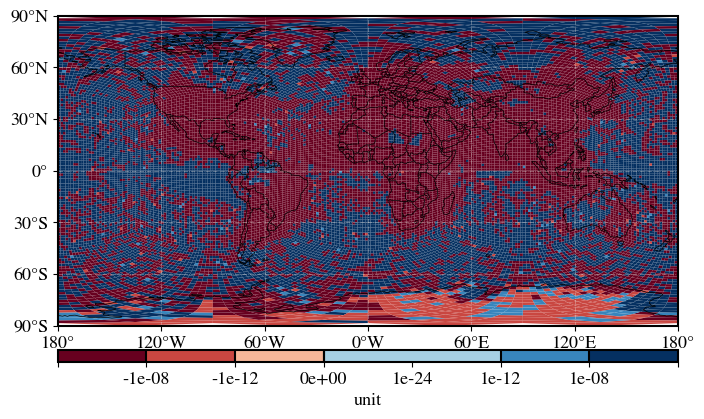

In [44]:
fig = plt.figure(figsize=(8,6))
panel = plt.subplot(111,projection=crs.PlateCarree())
diff = data2['EXTINCT'][-1] - data['EXTINCT'][-1]
get_plots( diff,ax=panel,cmap='RdBu',figsize=fig,levels=[-1e-6,-1e-8,-1e-12,0,1e-24,1e-12,1e-8,1e-6],\
             scrip_file='/global/u2/h/hass877/MODS/ne30pg2_SCRIP.nc',gridLines=False,\
                lon_range=[-180,180], lat_range=[-90,90],
                ).get_map()

In [43]:
diff.max().values

array(1.95624323e-05)

In [22]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap
import pandas as pd
#from asediag_utils import rounding, gen_colbar_range
#from asediag.gen_scrip_file import gen_scrip

def rounding(n):
    if (type(n)==str) or (np.isnan(n)):
        return str('-')
    elif ((abs(n)>1e-4) and (abs(n)<1e4)):
        try:
            sgn = '-' if n<0 else ''
            num = format(abs(n)-int(abs(n)),'f')
            if int(num[2:])<1:
                d = str((abs(n)))
                return sgn + d
            else:
                for i,e in enumerate(num[2:]):
                    if e!= '0':
                        if i==0:
                            d = str(int(abs(n))) + (num[1:i+5])
                        else:
                            d = str(int(abs(n))) + (num[1:i+4])
                        return sgn+d
        except:
            return '-'
    else:
        return '{:.0e}'.format(n)


class gen_colbar_range(object):
    
    def __init__(self,**kwargs):
        self.v1 = kwargs.get('v1',None)
        self.v2 = kwargs.get('v2',None)
        self.diff = kwargs.get('diff',None)
        self.factor = kwargs.get('factor',None)
    
    def hmap(self):
        if self.factor != None:
            factor = self.factor
            mstd1h = (np.mean(self.v1.values)+factor*np.std(self.v1.values))
            mstd1l = (np.mean(self.v1.values)-factor*np.std(self.v1.values))
            v1 = self.v1[(self.v1<=mstd1h) & (self.v1>=mstd1l)]
            mstd1h = (np.mean(self.v2.values)+factor*np.std(self.v2.values))
            mstd1l = (np.mean(self.v2.values)-factor*np.std(self.v2.values))
            v2 = self.v2[(self.v2<=mstd1h) & (self.v2>=mstd1l)]
            aagg = (np.max(v1.values)+np.max(v2.values))/2
        else:
            aagg = (np.max(self.v1.values)+np.max(self.v2.values))/2
        
        aagg = np.log10(aagg)
        expo = np.floor(aagg)
        bbgg = aagg - expo
        if 10**(bbgg)<2.:
            s1 = [5*10**(expo-4),1*10**(expo-3),2*10**(expo-3), \
                    5*10**(expo-3),1*10**(expo-2),2*10**(expo-2), \
                    5*10**(expo-2),1*10**(expo-1),2*10**(expo-1), \
                    5*10**(expo-1),10**expo,      2.*10**expo]
        elif 10**(bbgg)<5.:
            s1 = [1*10**(expo-3),2*10**(expo-3),5*10**(expo-3), \
                    1*10**(expo-2),2*10**(expo-2),5*10**(expo-2), \
                    1*10**(expo-1),2*10**(expo-1),5*10**(expo-1), \
                    10**expo,      2.*10**expo,   5.*10**expo]
        else:
            s1 = [2*10**(expo-3),5*10**(expo-3),1*10**(expo-2), \
                    2*10**(expo-2),5*10**(expo-2),1*10**(expo-1), \
                    2*10**(expo-1),5*10**(expo-1),10**expo,       \
                    2.*10**expo,   5.*10**expo,   10**(expo+1)]
        return s1
    
    def hdiff(self):
        aagg = np.max(abs(self.diff).values)
        aagg = np.log10(aagg)
        expo = np.ceil(aagg)
        s1 = np.array([-100,-70,-50,-20,-10,-5,-2,-1,1,2,5,10,20,50,70,100])*(10**(expo)/1e3)
        return list(s1)
    
    def vmap(self):
        s1=[0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
        aagg=(np.max(self.v1).values+np.max(self.v2).values)/2
        aagg=np.log10(aagg)
        s1=np.array(s1)*(10**(np.round(aagg-2.7)))
        return list(s1)
    
    def vdiff(self):
        s2=[-100,-50.,-20,-10,-5,-2,2,5,10,20,50,100]
        if (abs(np.max(self.v1).values)/abs(np.max(self.diff).values))<10:
            aagg=0.25*0.1*(abs(np.max(self.diff).values)+abs(np.min(self.diff).values))/2
        else:                           
            aagg=0.25*(abs(np.max(self.diff).values)+abs(np.min(self.diff).values))/2
        aagg=np.log10(aagg)
        s1 = np.array(s2)*(10**(np.round(aagg-1.7)))*10
        return list(s1)
    
class get_plots(object):
    
    def __init__(self,var,ax,**kwargs):
        self.var = var
        self.ax = ax
        self.xint = kwargs.get('xint',None)
        self.yint = kwargs.get('yint',None)
        self.figsize = kwargs.get('figsize',None)
        self.scrip_file = kwargs.get('scrip_file',None)
        self.lat_range = kwargs.get('lat_range',[-90,90])
        self.lon_range = kwargs.get('lon_range',[-180,180])
        self.cm = kwargs.get('cmap',plt.cm.jet)
        self.labelsize = kwargs.get('labelsize',13)
        self.unit = kwargs.get('unit','unit')
        self.gridLines = kwargs.get('gridLines',True)
        self.colbar = kwargs.get('colbar',True)
        self.map_proj = kwargs.get('projection',crs.PlateCarree())
        self.res = kwargs.get('res','110m')
        self.cbs = kwargs.get('cbs',0)
        self.cbe = kwargs.get('cbe',-1)
        self.cbi = kwargs.get('cbi',1)
        self.verts = kwargs.get('verts',None)
        self.rr = kwargs.get('levels',None)
    
        
    def get_verts(self):
        try:
            corner_lon,corner_lat,center_lon,center_lat = gen_scrip(res=self.scrip_file).get_scrip_file()
        except:
            ds_scrip=xr.open_dataset(self.scrip_file)
            corner_lon = np.copy( ds_scrip.grid_corner_lon.values )
            corner_lat = np.copy( ds_scrip.grid_corner_lat.values )
            center_lon = np.copy( ds_scrip.grid_center_lon.values )
            
        if ((np.min(self.lon_range) < 0) & (np.max(corner_lon) > 180)):
            corner_lon[corner_lon > 180.] -= 360.
        
        lons_corners = np.copy(corner_lon.reshape(corner_lon.shape[0],corner_lon.shape[1],1))
        lats_corners = np.copy(corner_lat.reshape(corner_lat.shape[0],corner_lat.shape[1],1))
        lons_corners[lons_corners > 180.] -= 360
        center_lon[center_lon > 180.] -= 360
        
        lon_maxmin = np.max(lons_corners,axis=(1,2)) - np.min(lons_corners,axis=(1,2))
        g180 = np.where(lon_maxmin>180)[0]
        g180l0 = np.where(np.mean(lons_corners[g180],axis=(1,2)) <= 0)[0]
        tmp_lons_corners = lons_corners[g180[g180l0]].copy()
        tmp_lons_corners = np.where(lons_corners[g180[g180l0]]<0,180,tmp_lons_corners)
        lons_corners = np.append(lons_corners,tmp_lons_corners,axis=0)
        lats_corners = np.append(lats_corners,lats_corners[g180[g180l0]],axis=0)
        lons_corners[g180[g180l0]] = np.where(lons_corners[g180[g180l0]]>0,-180,lons_corners[g180[g180l0]])
        self.var = np.append(self.var,self.var[g180[g180l0]],axis=0)
        
        g180g0 = np.where(np.mean(lons_corners[g180],axis=(1,2)) > 0)[0]
        tmp_lons_corners = lons_corners[g180[g180g0]].copy()
        tmp_lons_corners = np.where(lons_corners[g180[g180g0]]>0,-180,tmp_lons_corners)
        lons_corners = np.append(lons_corners,tmp_lons_corners,axis=0)
        lats_corners = np.append(lats_corners,lats_corners[g180[g180g0]],axis=0)
        lons_corners[g180[g180g0]] = np.where(lons_corners[g180[g180g0]]<0,180,lons_corners[g180[g180g0]])
        self.var = np.append(self.var,self.var[g180[g180g0]],axis=0)

        verts = np.concatenate((lons_corners, lats_corners), axis=2)
            
        return self.var, verts
        
    def get_map(self):
        kwd_polycollection = {}
        kwd_pcolormesh = {}
        if self.gridLines == True:
            kwd_polycollection['edgecolor'] = 'k'
            kwd_polycollection['lw'] = 0.05
            kwd_pcolormesh['edgecolors'] = 'k'
            kwd_pcolormesh['lw'] = 0.01
        plt.rcParams['font.family'] = 'STIXGeneral'
        ## levels
        if self.rr == None:
            var1 = self.var.stack(grid=self.var.dims)
            var1 = var1.dropna("grid", how="all")
            self.rr = gen_colbar_range(v1=var1,v2=var1).hmap()
        ranges=self.rr
        self.ax.set_global()
        clen=len(np.arange(0,257)[self.cbs:self.cbe:self.cbi])
        try:
            self.cm = ListedColormap(self.cm.colors[self.cbs:self.cbe:self.cbi])
        except:
            self.cm = self.cm
            print('Cannot subscript Segmented Colormap!')
        if ('.nc' in str(self.scrip_file)) | (self.scrip_file.isdigit()):
            var, verts = self.get_verts()
            im = PolyCollection(verts,cmap=self.cm,**kwd_polycollection,\
                               norm=matplotlib.colors.BoundaryNorm(boundaries=ranges, ncolors=clen) )
            im.set_array(var)
            self.ax.add_collection(im)
        else:
            try:
                lon = self.var.lon
                lat = self.var.lat
            except:
                lon = self.var.longitude
                lat = self.var.latitude
            im = self.ax.pcolormesh(lon, lat, self.var, cmap=self.cm, transform=self.map_proj, \
                                    **kwd_pcolormesh, norm=matplotlib.colors.BoundaryNorm(boundaries=ranges, ncolors=clen) )
        
        self.ax.set_xlim(self.lon_range)
        if self.xint == None:
            self.xint = np.around((self.lon_range[1]-self.lon_range[0])/6)
        xticklabels=np.arange(self.lon_range[0],self.lon_range[1]+self.xint,self.xint)
        self.ax.set_ylim(self.lat_range)
        if self.yint == None:
            self.yint = np.around((self.lat_range[1]-self.lat_range[0])/6)
        yticklabels=np.arange(self.lat_range[0],self.lat_range[1]+self.yint,self.yint)
        self.ax.coastlines(resolution=self.res,lw=0.5,edgecolor='k')
        self.ax.add_feature(cfeature.BORDERS.with_scale(self.res),lw=0.5,edgecolor='k')
        self.ax.set_xticks(xticklabels,crs=self.map_proj)
        self.ax.set_yticks(yticklabels,crs=self.map_proj)
        self.ax.tick_params(labelsize=self.labelsize)
        self.ax.set_xlabel('')
        self.ax.set_ylabel('')
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        self.ax.xaxis.set_major_formatter(lon_formatter)
        self.ax.yaxis.set_major_formatter(lat_formatter)
        self.ax.grid( lw=0.5, color='#EBE7E0', alpha=0.5, linestyle='-.')
        ## Take care of the colorbar
        fig = self.ax.figure
        ## rounding the colorbar ticks
        s1 = pd.DataFrame(ranges)
        s2 = s1.applymap(lambda x: rounding(x))[0].tolist()
        cbar_ticks=list(map(str,s2))
        cbar_ticks = [i.replace('.0','') if i[-2:]=='.0' else i for i in cbar_ticks]
        cbar_ticks = [i.rstrip('0') if '.' in i else i for i in cbar_ticks]
        if len(cbar_ticks) > 12:
            cbar_ticks[::2]=['']*len(cbar_ticks[::2])
        else:
            cbar_ticks[0]=''
            cbar_ticks[-1]=''
        ## Dynamic page size depending on the lat/lon ranges or panel size
        if self.figsize != None:
            positions = self.ax.get_position()
            gapy = positions.y0-positions.y1
            gapx = positions.x0-positions.x1
            ratio = gapy/gapx
            if (ratio < 0.6) and (ratio > 0.4):
                self.figsize.set_size_inches(18,10,forward=True)
                plt.draw()
            elif (ratio < 0.4):
                self.figsize.set_size_inches(18,7,forward=True)
                plt.draw()
            elif (ratio > 1) and (ratio < 1.3):
                self.figsize.set_size_inches(16,16,forward=True)
                plt.draw()
            elif (ratio > 1.3):
                self.figsize.set_size_inches(14,18,forward=True)
                plt.draw()

        positions = self.ax.get_position()
        if self.colbar==True:
            cax = fig.add_axes([positions.x0,positions.y0-0.06,positions.x1-positions.x0,0.02])
            cbar = fig.colorbar(im,cax=cax,orientation='horizontal',ticks=ranges,extend='neither',fraction=0.08,drawedges=True)
            cbar.ax.set_xticklabels(cbar_ticks, size=self.labelsize )
            cbar.set_label(label=self.unit,size=self.labelsize)
            cbar.outline.set_linewidth(1.5)
            cbar.dividers.set_linewidth(1.5)
        ## panel box thickness
        plt.setp(self.ax.spines.values(),lw=1.5)
        return im

        


In [73]:
cdatadef.index[0]

'Burden (TgS)'

/tmp/ipykernel_1509818/1763027090.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[hatch_array[i]] if not np.isnan(hatch_array[i]) else ''
/tmp/ipykernel_1509818/1763027090.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[hatch_array[i]] if not np.isnan(hatch_array[i]) else ''
/tmp/ipykernel_1509818/1763027090.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern =

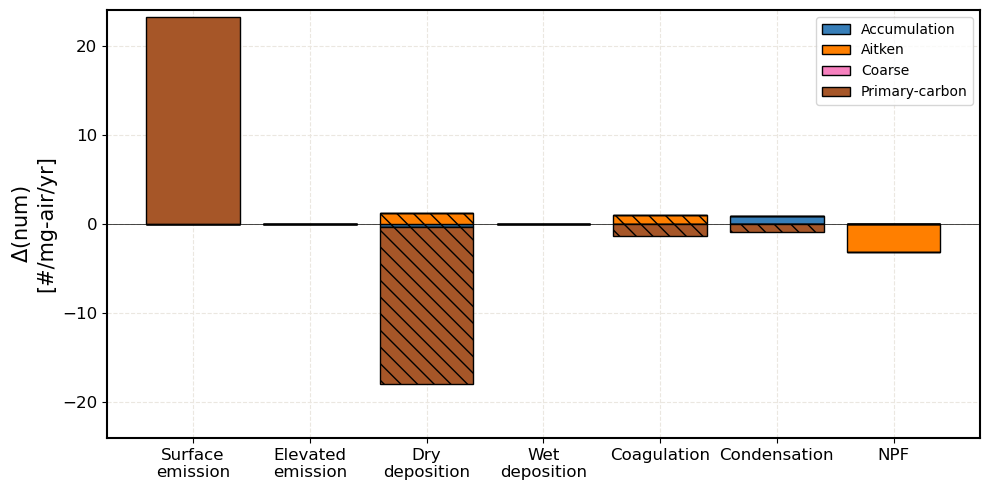

In [10]:
cdatadef = get_tables(dfile,'num',reg=None,loc='HAE',mod='eam',indl=None,land=False)
cdatase = get_tables(pfile,'num',reg=None,loc='HAE',mod='eam',indl=None,land=False)

cdatadiff = cdatase[cdatase.columns[1:]] - cdatadef[cdatase.columns[1:]]
aa = cdatadiff[["num_a1", "num_a2", "num_a3", "num_a4", "num_c1", "num_c2", "num_c3", "num_c4"]]

ll=['surface emission','elevated emission','Dry deposition','Wet deposition',\
    'coagulation (sfcoag1)','condensation-aging','sfnnuc1']
lbs = ['Surface\nemission','Elevated\nemission','Dry\ndeposition','Wet\ndeposition',\
       'Coagulation','Condensation','NPF']
# Initialize the bottom arrays for positive and negative values
oldvals_pos = np.zeros(len(ll))
oldvals_neg = np.zeros(len(ll))
r = range(len(ll))
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
barWidth = 0.85
hatches = {1: '', -1: '\\\\'}
for nn,cc,mode in zip(["num_a1", "num_a2", "num_a3", "num_a4"],\
                 ['#377eb8','#ff7f00','#f781bf','#a65628'],\
                ['Accumulation','Aitken','Coarse','Primary-carbon']):
    hatch_array = cdatase.loc[ll][nn]/np.abs(cdatase.loc[ll][nn]).astype(float)
    vals = (aa.loc[ll][nn].astype(float))
    pos_vals = np.where(vals > 0, vals, 0)
    neg_vals = np.where(vals < 0, vals, 0)
    ax.bar(r[i], pos_vals[i],edgecolor='k',zorder=4, bottom=oldvals_pos[i], color=cc, \
               hatch=hatch_pattern, label=f'{mode}')
    for i in range(len(r)):
        hatch_pattern = hatches[hatch_array[i]] if not np.isnan(hatch_array[i]) else ''
        ax.bar(r[i], pos_vals[i],edgecolor='k',zorder=4, bottom=oldvals_pos[i], color=cc, \
               hatch=hatch_pattern)
        ax.bar(r[i], neg_vals[i],edgecolor='k',zorder=4, bottom=oldvals_neg[i], color=cc, \
               hatch=hatch_pattern)
    #ax.bar(r, pos_vals, bottom=oldvals_pos, edgecolor='k',zorder=4, width=barWidth, color=cc,label=f'{mode}')
    #ax.bar(r, neg_vals, bottom=oldvals_neg, edgecolor='k',zorder=4, width=barWidth, color=cc)
    #plt.bar(r, vals, bottom=oldvals,color=cc)
    oldvals_pos += pos_vals
    oldvals_neg += neg_vals

# Adding y=0 line
ax.axhline(0, color='black', linewidth=0.5,zorder=4)
plt.tick_params(labelsize=12)
# Adding titles, labels, and legend
#plt.title('Stacked Bar Plot with Positive and Negative Values')
#plt.xlabel('Categories')
plt.ylabel('$\Delta$(num)\n[#/mg-air/yr]',fontsize=15)
plt.xticks(np.array(r), lbs)
plt.legend(loc='upper right')
ax.grid(linestyle='--',color='#EBE7E0',zorder=3)
ax.set_ylim([-24,24])
plt.setp(ax.spines.values(),lw=1.5)

plt.tight_layout()
#plt.show()

/tmp/ipykernel_1509818/3378892178.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[hatch_array[i]] if not np.isnan(hatch_array[i]) else ''
/tmp/ipykernel_1509818/3378892178.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[hatch_array[i]] if not np.isnan(hatch_array[i]) else ''
/tmp/ipykernel_1509818/3378892178.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern =

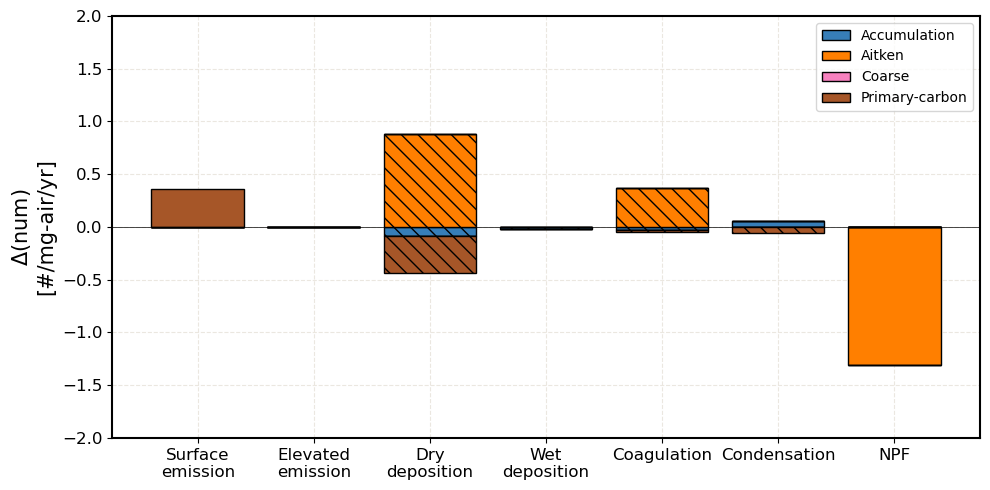

In [13]:
cdatadef = get_tables(dfile,'num',reg=None,loc='ENA',mod='eam',indl=None,land=False)
cdatase = get_tables(pfile,'num',reg=None,loc='ENA',mod='eam',indl=None,land=False)

cdatadiff = cdatase[cdatase.columns[1:]] - cdatadef[cdatase.columns[1:]]
aa = cdatadiff[["num_a1", "num_a2", "num_a3", "num_a4", "num_c1", "num_c2", "num_c3", "num_c4"]]

ll=['surface emission','elevated emission','Dry deposition','Wet deposition',\
    'coagulation (sfcoag1)','condensation-aging','sfnnuc1']
lbs = ['Surface\nemission','Elevated\nemission','Dry\ndeposition','Wet\ndeposition',\
       'Coagulation','Condensation','NPF']
# Initialize the bottom arrays for positive and negative values
oldvals_pos = np.zeros(len(ll))
oldvals_neg = np.zeros(len(ll))
r = range(len(ll))
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
barWidth = 0.85
hatches = {1: '', -1: '\\\\'}
for nn,cc,mode in zip(["num_a1", "num_a2", "num_a3", "num_a4"],\
                 ['#377eb8','#ff7f00','#f781bf','#a65628'],\
                ['Accumulation','Aitken','Coarse','Primary-carbon']):
    hatch_array = cdatase.loc[ll][nn]/np.abs(cdatase.loc[ll][nn]).astype(float)
    vals = (aa.loc[ll][nn].astype(float))
    pos_vals = np.where(vals > 0, vals, 0)
    neg_vals = np.where(vals < 0, vals, 0)
    ax.bar(r[i], pos_vals[i],edgecolor='k',zorder=4, bottom=oldvals_pos[i], color=cc, \
               hatch=hatch_pattern, label=f'{mode}')
    for i in range(len(r)):
        hatch_pattern = hatches[hatch_array[i]] if not np.isnan(hatch_array[i]) else ''
        ax.bar(r[i], pos_vals[i],edgecolor='k',zorder=4, bottom=oldvals_pos[i], color=cc, \
               hatch=hatch_pattern)
        ax.bar(r[i], neg_vals[i],edgecolor='k',zorder=4, bottom=oldvals_neg[i], color=cc, \
               hatch=hatch_pattern)
    #ax.bar(r, pos_vals, bottom=oldvals_pos, edgecolor='k',zorder=4, width=barWidth, color=cc,label=f'{mode}')
    #ax.bar(r, neg_vals, bottom=oldvals_neg, edgecolor='k',zorder=4, width=barWidth, color=cc)
    #plt.bar(r, vals, bottom=oldvals,color=cc)
    oldvals_pos += pos_vals
    oldvals_neg += neg_vals

# Adding y=0 line
ax.axhline(0, color='black', linewidth=0.5,zorder=4)
plt.tick_params(labelsize=12)
# Adding titles, labels, and legend
#plt.title('Stacked Bar Plot with Positive and Negative Values')
#plt.xlabel('Categories')
plt.ylabel('$\Delta$(num)\n[#/mg-air/yr]',fontsize=15)
plt.xticks(np.array(r), lbs)
plt.legend(loc='upper right')
ax.grid(linestyle='--',color='#EBE7E0',zorder=3)
ax.set_ylim([-2,2])
plt.setp(ax.spines.values(),lw=1.5)

plt.tight_layout()
#plt.show()

/tmp/ipykernel_1509818/1625523781.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[hatch_array[i]] if not np.isnan(hatch_array[i]) else ''
/tmp/ipykernel_1509818/1625523781.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern = hatches[hatch_array[i]] if not np.isnan(hatch_array[i]) else ''
/tmp/ipykernel_1509818/1625523781.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hatch_pattern =

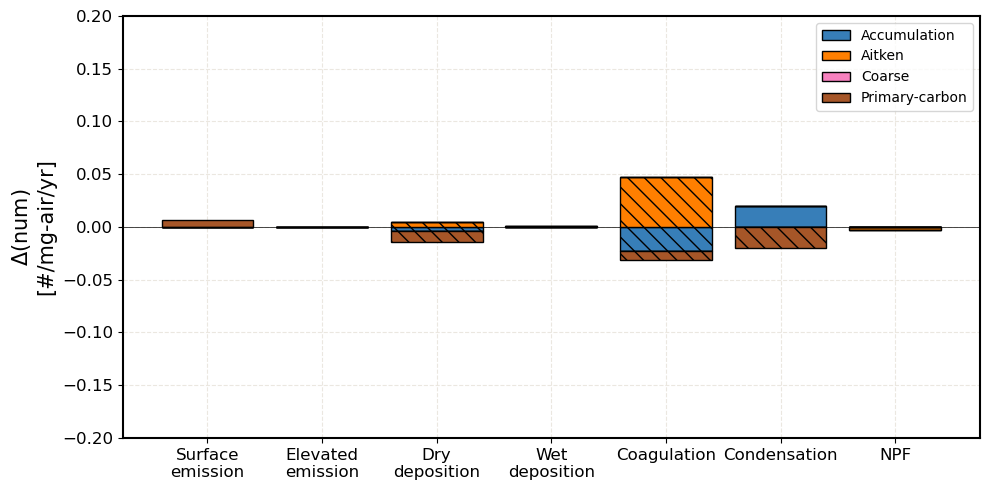

In [16]:
cdatadef = get_tables(dfile,'num',reg=None,loc='NSA',mod='eam',indl=None,land=False)
cdatase = get_tables(pfile,'num',reg=None,loc='NSA',mod='eam',indl=None,land=False)

cdatadiff = cdatase[cdatase.columns[1:]] - cdatadef[cdatase.columns[1:]]
aa = cdatadiff[["num_a1", "num_a2", "num_a3", "num_a4", "num_c1", "num_c2", "num_c3", "num_c4"]]

ll=['surface emission','elevated emission','Dry deposition','Wet deposition',\
    'coagulation (sfcoag1)','condensation-aging','sfnnuc1']
lbs = ['Surface\nemission','Elevated\nemission','Dry\ndeposition','Wet\ndeposition',\
       'Coagulation','Condensation','NPF']
# Initialize the bottom arrays for positive and negative values
oldvals_pos = np.zeros(len(ll))
oldvals_neg = np.zeros(len(ll))
r = range(len(ll))
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
barWidth = 0.85
hatches = {1: '', -1: '\\\\'}
for nn,cc,mode in zip(["num_a1", "num_a2", "num_a3", "num_a4"],\
                 ['#377eb8','#ff7f00','#f781bf','#a65628'],\
                ['Accumulation','Aitken','Coarse','Primary-carbon']):
    hatch_array = cdatase.loc[ll][nn]/np.abs(cdatase.loc[ll][nn]).astype(float)
    vals = (aa.loc[ll][nn].astype(float))
    pos_vals = np.where(vals > 0, vals, 0)
    neg_vals = np.where(vals < 0, vals, 0)
    ax.bar(r[i], pos_vals[i],edgecolor='k',zorder=4, bottom=oldvals_pos[i], color=cc, \
               hatch=hatch_pattern, label=f'{mode}')
    for i in range(len(r)):
        hatch_pattern = hatches[hatch_array[i]] if not np.isnan(hatch_array[i]) else ''
        ax.bar(r[i], pos_vals[i],edgecolor='k',zorder=4, bottom=oldvals_pos[i], color=cc, \
               hatch=hatch_pattern)
        ax.bar(r[i], neg_vals[i],edgecolor='k',zorder=4, bottom=oldvals_neg[i], color=cc, \
               hatch=hatch_pattern)
    #ax.bar(r, pos_vals, bottom=oldvals_pos, edgecolor='k',zorder=4, width=barWidth, color=cc,label=f'{mode}')
    #ax.bar(r, neg_vals, bottom=oldvals_neg, edgecolor='k',zorder=4, width=barWidth, color=cc)
    #plt.bar(r, vals, bottom=oldvals,color=cc)
    oldvals_pos += pos_vals
    oldvals_neg += neg_vals

# Adding y=0 line
ax.axhline(0, color='black', linewidth=0.5,zorder=4)
plt.tick_params(labelsize=12)
# Adding titles, labels, and legend
#plt.title('Stacked Bar Plot with Positive and Negative Values')
#plt.xlabel('Categories')
plt.ylabel('$\Delta$(num)\n[#/mg-air/yr]',fontsize=15)
plt.xticks(np.array(r), lbs)
plt.legend(loc='upper right')
ax.grid(linestyle='--',color='#EBE7E0',zorder=3)
ax.set_ylim([-0.2,0.2])
plt.setp(ax.spines.values(),lw=1.5)

plt.tight_layout()
#plt.show()

In [19]:
pos_vals

array([0.00652316, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])